<a href="https://colab.research.google.com/github/DawnSpider96/L361-Federated-Learning/blob/release/Copy_of_L361_2025_Lab_1_From_Centralised_To_Federated_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencies
---


In [1]:
# `pip` could produce some errors. Do not worry about them.
# The execution has been verified; it's working anyway.
# ! pip install --quiet --upgrade "pip"
# ! pip install --quiet matplotlib tqdm seaborn
# ! pip install git+https://github.com/Iacob-Alexandru-Andrei/flower.git@teaching \
#     torch torchvision ray=="2.6.3"

### Imports.


In [2]:
import sys
sys.path.append('../../')
print(sys.path)

['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/dawn/venvs/fed/lib/python3.10/site-packages', '/home/dawn/repos/cycle-consistent-model-merging/src', '../../']


In [3]:
import random
from pathlib import Path
import tarfile
from typing import Any
from logging import INFO
from collections import defaultdict, OrderedDict
from collections.abc import Sequence, Callable
import numbers

import numpy as np
import torch
from torch import nn
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset
from enum import IntEnum
import flwr
from flwr.server import History, ServerConfig
from flwr.server.strategy import FedAvgM as FedAvg, Strategy
from c2m3.match.fed_frank_wolfe_strategy import FrankWolfeSync
from flwr.common import log, NDArrays, Scalar, Parameters, ndarrays_to_parameters
from flwr.client.client import Client

from c2m3.common.client_utils import (
    Net,
    load_femnist_dataset,
    get_network_generator_cnn as get_network_generator,
    train_femnist,
    test_femnist,
    save_history,
    get_model_parameters,
    set_model_parameters
)


# Add new seeds here for easy autocomplete
class Seeds(IntEnum):
    """Seeds for reproducibility."""

    DEFAULT = 1337


np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


PathType = Path | str | None


def get_device() -> str:
    """Get the device (cuda, mps, cpu)."""
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = "mps"
    return device

2025-03-05 17:01:27.897839: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-05 17:01:28.080037: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-05 17:01:29.229615: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dawn/venvs/fed/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-05 17:01:31,664	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [4]:
home_dir = Path.cwd() / ".."
dataset_dir: Path = home_dir / "femnist"
data_dir: Path = dataset_dir / "data"
centralized_partition: Path = dataset_dir / "client_data_mappings" / "centralized"
centralized_mapping: Path = dataset_dir / "client_data_mappings" / "centralized" / "0"
federated_partition: Path = dataset_dir / "client_data_mappings" / "fed_natural"

# Decompress dataset
if not dataset_dir.exists():
    with tarfile.open(home_dir / "femnist.tar.gz", "r:gz") as tar:
        tar.extractall(path=home_dir)
    log(INFO, "Dataset extracted in %s", dataset_dir)

## 5. Building a Flower FL client.
---

Our first client abstraction shall be as simple as possible and will require adjustment to match the structure that the flower framework expects. However, it shall be conceptually identical and require only light API changes.

Moving from centralised ML to server-client FL requires us to provide a means of communication between the respective server and clients. The Flower Framework is ML-framework agnostic and allows various means of transmitting model parameters in the federated network. Since you may have limited resources in these labs, we will only tangentially follow the Flower framework while keeping the computational requirements to a minimum.

The simplest and most common encoding for models is the mere transmission of model parameters as NumPy arrays instead of the stateful PyTorch models. The following functions allow for seamless conversions between the two.

With them in place, making the client abstraction compatible with Flower requires only a bit of boilerplate such as allowing NumPy arrays to be received and sent instead of PyTorch models. To achieve this, we provide a model generator capable of creating a network and using the received parameters.

To keep client objects light in the memory when not used by the Flower FL simulator, the model generator is only called as needed for either `fit` or `evaluate`.

In [5]:
class FlowerRayClient(flwr.client.NumPyClient):
    """Flower client for the FEMNIST dataset."""

    def __init__(
        self,
        cid: int,
        partition_dir: Path,
        model_generator: Callable[[], Module],
    ) -> None:
        """Init the client with its unique id and the folder to load data from.

        Parameters
        ----------
            cid (int): Unique client id for a client used to map it to its data
                partition
            partition_dir (Path): The directory containing data for each
                client/client id
            model_generator (Callable[[], Module]): The model generator function
        """
        self.cid = cid
        log(INFO, "cid: %s", self.cid)
        self.partition_dir = partition_dir
        self.device = str(
            torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        )
        self.model_generator: Callable[[], Module] = model_generator
        self.properties: dict[str, Scalar] = {"tensor_type": "numpy.ndarray"}

    def set_parameters(self, parameters: NDArrays) -> Module:
        """Load weights inside the network.

        Parameters
        ----------
            parameters (NDArrays): set of weights to be loaded.

        Returns
        -------
            [Module]: Network with new set of weights.
        """
        net = self.model_generator()
        return set_model_parameters(net, parameters)

    def get_parameters(self, config: dict[str, Scalar]) -> NDArrays:
        """Return weights from a given model.

        If no model is passed, then a local model is created.
        This can be used to initialise a model in the
        server.
        The config param is not used but is mandatory in Flower.

        Parameters
        ----------
            config (dict[int, Scalar]): dictionary containing configuration info.

        Returns
        -------
            NDArrays: weights from the model.
        """
        net = self.model_generator()
        return get_model_parameters(net)

    def fit(
        self, parameters: NDArrays, config: dict[str, Scalar]
    ) -> tuple[NDArrays, int, dict]:
        """Receive and train a model on the local client data.

        It uses parameters from the config dict

        Parameters
        ----------
            net (NDArrays): Pytorch model parameters
            config (dict[str, Scalar]): dictionary describing the training parameters

        Returns
        -------
            tuple[NDArrays, int, dict]: Returns the updated model, the size of the local
                dataset and other metrics
        """
        # Only create model right before training/testing
        # To lower memory usage when idle
        net = self.set_parameters(parameters)
        net.to(self.device)

        train_loader: DataLoader = self._create_data_loader(config, name="train")
        train_loss = self._train(net, train_loader=train_loader, config=config)
        return get_model_parameters(net), len(train_loader), {"train_loss": train_loss}

    def evaluate(
        self, parameters: NDArrays, config: dict[str, Scalar]
    ) -> tuple[float, int, dict]:
        """Receive and test a model on the local client data.

        It uses parameters from the config dict

        Parameters
        ----------
            net (NDArrays): Pytorch model parameters
            config (dict[str, Scalar]): dictionary describing the testing parameters

        Returns
        -------
            tuple[float, int, dict]: Returns the loss accumulate during testing, the
                size of the local dataset and other metrics such as accuracy
        """
        net = self.set_parameters(parameters)
        net.to(self.device)

        test_loader: DataLoader = self._create_data_loader(config, name="test")
        loss, accuracy = self._test(net, test_loader=test_loader, config=config)
        return loss, len(test_loader), {"local_accuracy": accuracy}

    def _create_data_loader(self, config: dict[str, Scalar], name: str) -> DataLoader:
        """Create the data loader using the specified config parameters.

        Parameters
        ----------
            config (dict[str, Scalar]): dictionary containing dataloader and dataset
                parameters
            mode (str): Load the training or testing set for the client

        Returns
        -------
            DataLoader: A pytorch dataloader iterable for training/testing
        """
        batch_size = int(config["batch_size"])
        num_workers = int(config["num_workers"])
        dataset = self._load_dataset(name)
        return DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            drop_last=(name == "train"),
        )

    def _load_dataset(self, name: str) -> Dataset:
        full_file: Path = self.partition_dir / str(self.cid)
        return load_femnist_dataset(
            mapping=full_file,
            name=name,
            data_dir=data_dir,
        )

    def _train(
        self, net: Module, train_loader: DataLoader, config: dict[str, Scalar]
    ) -> float:
        return train_femnist(
            net=net,
            train_loader=train_loader,
            epochs=int(config["epochs"]),
            device=self.device,
            optimizer=torch.optim.AdamW(
                net.parameters(),
                lr=float(config["client_learning_rate"]),
                weight_decay=float(config["weight_decay"]),
            ),
            criterion=torch.nn.CrossEntropyLoss(),
            max_batches=int(config["max_batches"]),
        )

    def _test(
        self, net: Module, test_loader: DataLoader, config: dict[str, Scalar]
    ) -> tuple[float, float]:
        return test_femnist(
            net=net,
            test_loader=test_loader,
            device=self.device,
            criterion=torch.nn.CrossEntropyLoss(),
            max_batches=int(config["max_batches"]),
        )

    def get_properties(self, config: dict[str, Scalar]) -> dict[str, Scalar]:
        """Return properties for this client.

        Parameters
        ----------
            config (dict[str, Scalar]): Options to be used for selecting specific
            properties.

        Returns
        -------
            dict[str, Scalar]: Returned properties.
        """
        return self.properties

    def get_train_set_size(self) -> int:
        """Return the client train set size.

        Returns
        -------
            int: train set size of the client.
        """
        return len(self._load_dataset("train"))  # type: ignore[reportArgumentType]

    def get_test_set_size(self) -> int:
        """Return the client test set size.

        Returns
        -------
            int: test set size of the client.
        """
        return len(self._load_dataset("test"))  # type: ignore[reportArgumentType]


def fit_client_seeded(
    client: FlowerRayClient,
    params: NDArrays,
    conf: dict[str, Any],
    seed: Seeds = Seeds.DEFAULT,
    **kwargs: Any,
) -> tuple[NDArrays, int, dict]:
    """Wrap to always seed client training."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return client.fit(params, conf, **kwargs)

The underlying FL simulator used by Flower is based on [Ray](https://www.ray.io/). It expects each client only to require a client ID for instantiation. Therefore, using the following generator function, we can determine the specific network used for FL together with the FEMNIST partition to which the `cid` refers.

While we will not use `Ray` in this lab due to its heavyweight nature, we will keep all code API compatible with the default flower framework.

In [6]:
def get_flower_client_generator(
    model_generator: Callable[[], Module],
    partition_dir: Path,
    mapping_fn: Callable[[int], int] | None = None,
) -> Callable[[str], FlowerRayClient]:
    """Wrap the client instance generator.

    This provides the client generator with a model generator function.
    Also, the partition directory must be passed.
    A mapping function could be used for filtering/ordering clients.

    Parameters
    ----------
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.
        mapping_fn (Optional[Callable[[int], int]]): function mapping sorted/filtered
            ids to real cid.

    Returns
    -------
        Callable[[str], FlowerRayClient]: client instance.
    """

    def client_fn(cid: str) -> FlowerRayClient:
        """Create a single client instance given the client id `cid`.

        Parameters
        ----------
            cid (str): client id, Flower requires this to be of type str.

        Returns
        -------
            FlowerRayClient: client instance.
        """
        return FlowerRayClient(
            cid=mapping_fn(int(cid)) if mapping_fn is not None else int(cid),
            partition_dir=partition_dir,
            model_generator=model_generator,
        )

    return client_fn

To ensure the Flower client behaves the same as our simple demo client, a simple test using the centralised partition we defined earlier should suffice.

In [7]:
network_generator = get_network_generator()
seed_net: Net = network_generator()
seed_model_params: NDArrays = get_model_parameters(seed_net)

centralized_flower_client_generator: Callable[[str], FlowerRayClient] = (
    get_flower_client_generator(network_generator, centralized_partition)
)
centralized_flower_client = centralized_flower_client_generator(str(0))

INFO flwr 2025-03-05 17:01:36,012 | 2290543087.py:21 | cid: 0


2025-03-05 17:01:36 INFO     cid: 0                                                                         ]8;id=614242;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=767447;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

In [8]:
seed_net

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=62, bias=True)
)

In [9]:
seed_net.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-0.1687, -0.0018,  0.0492, -0.0310, -0.1198],
                        [-0.1885,  0.0340,  0.0787, -0.1295, -0.0962],
                        [ 0.0834,  0.0324, -0.1770,  0.1067,  0.1511],
                        [-0.1027,  0.0402,  0.0832,  0.0041, -0.0374],
                        [ 0.1546, -0.0569,  0.1585,  0.1856, -0.1941]]],
              
              
                      [[[ 0.0943,  0.1154,  0.1787, -0.0138,  0.1351],
                        [-0.1492, -0.1147, -0.0823, -0.0529, -0.0068],
                        [ 0.0701,  0.0090,  0.0214,  0.0280, -0.1008],
                        [ 0.0416,  0.0831, -0.1684,  0.1052,  0.1083],
                        [-0.1703,  0.0304,  0.0741,  0.1640,  0.1074]]],
              
              
                      [[[ 0.0854, -0.1765,  0.1057,  0.1865,  0.1976],
                        [ 0.1198, -0.1540,  0.0689, -0.1652,  0.0416],
                        [-0.0303, -0.1599, -0.1664,  0

In [10]:
centralized_train_config: dict[str, Any] = {
    "epochs": 1,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

# Train parameters on the centralised dataset
trained_params, num_examples, train_metrics = fit_client_seeded(
    centralized_flower_client, params=seed_model_params, conf=centralized_train_config
)
log(INFO, "Train Metrics = %s", train_metrics)

INFO flwr 2025-03-05 17:01:39,186 | 4024557794.py:20 | Train Metrics = {'train_loss': 0.11729214794933795}


2025-03-05 17:01:39 INFO     Train Metrics = {'train_loss': 0.11729214794933795}                            ]8;id=614242;file:///tmp/ipykernel_387635/4024557794.py\flwr]8;;\:]8;id=767447;file:///tmp/ipykernel_387635/4024557794.py#20\20]8;;\

In [11]:
def sample_random_clients(
    total_clients: int,
    filter_less: int,
    partition: Path,
    seed: int | None = Seeds.DEFAULT,
) -> Sequence[int]:
    """Sample randomly clients.

    A filter on the client train set size is performed.

    Parameters
    ----------
        total_clients (int): total number of clients to sample.
        filter_less (int): max number of train samples for which the client is
            **discarded**.
        partition (Path): path to the folder containing the partitioning.
        seed (Optional[int], optional): seed for the random generator. Defaults to None.

    Returns
    -------
        Sequence[int]: list of sample client ids as int.
    """
    real_federated_cid_client_generator: Callable[[str], FlowerRayClient] = (
        get_flower_client_generator(network_generator, federated_partition)
    )
    if seed is not None:
        random.seed(seed)
    list_of_ids = []
    while len(list_of_ids) < total_clients:
        current_id = random.randint(0, 3229)
        if (
            real_federated_cid_client_generator(str(current_id)).get_train_set_size()
            > filter_less
        ):
            list_of_ids.append(current_id)
    return list_of_ids

While FEMNIST has more than 3000 clients, our small-scale experiments will not require more than 100 at any point.

In [12]:
total_clients: int = 100
list_of_ids = sample_random_clients(
    total_clients, 32, federated_partition
)

federated_client_generator: Callable[[str], FlowerRayClient] = (
    get_flower_client_generator(
        network_generator, federated_partition, lambda seq_id: list_of_ids[seq_id]
    )
)

INFO flwr 2025-03-05 17:01:39,216 | 2290543087.py:21 | cid: 2530


                    INFO     cid: 2530                                                                      ]8;id=598714;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=614242;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,222 | 2290543087.py:21 | cid: 2997


                    INFO     cid: 2997                                                                      ]8;id=402343;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=665713;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,226 | 2290543087.py:21 | cid: 1473


                    INFO     cid: 1473                                                                      ]8;id=214901;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=798528;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,229 | 2290543087.py:21 | cid: 2688


                    INFO     cid: 2688                                                                      ]8;id=446156;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=860291;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,233 | 2290543087.py:21 | cid: 2601


                    INFO     cid: 2601                                                                      ]8;id=733173;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=700576;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,237 | 2290543087.py:21 | cid: 1425


                    INFO     cid: 1425                                                                      ]8;id=773371;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=838929;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,241 | 2290543087.py:21 | cid: 1273


                    INFO     cid: 1273                                                                      ]8;id=623333;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=124295;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,245 | 2290543087.py:21 | cid: 1887


                    INFO     cid: 1887                                                                      ]8;id=328967;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=712258;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,250 | 2290543087.py:21 | cid: 2828


                    INFO     cid: 2828                                                                      ]8;id=632725;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=277721;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,255 | 2290543087.py:21 | cid: 823


                    INFO     cid: 823                                                                       ]8;id=648725;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=605340;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,260 | 2290543087.py:21 | cid: 3168


                    INFO     cid: 3168                                                                      ]8;id=945699;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=649850;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,264 | 2290543087.py:21 | cid: 220


                    INFO     cid: 220                                                                       ]8;id=206592;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=109670;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,269 | 2290543087.py:21 | cid: 1167


                    INFO     cid: 1167                                                                      ]8;id=837014;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=596302;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,273 | 2290543087.py:21 | cid: 1287


                    INFO     cid: 1287                                                                      ]8;id=349796;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=453161;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,277 | 2290543087.py:21 | cid: 2343


                    INFO     cid: 2343                                                                      ]8;id=813691;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=582389;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,281 | 2290543087.py:21 | cid: 2975


                    INFO     cid: 2975                                                                      ]8;id=224028;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=641102;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,285 | 2290543087.py:21 | cid: 740


                    INFO     cid: 740                                                                       ]8;id=812983;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=694825;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,289 | 2290543087.py:21 | cid: 206


                    INFO     cid: 206                                                                       ]8;id=612116;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=477296;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,294 | 2290543087.py:21 | cid: 100


                    INFO     cid: 100                                                                       ]8;id=788718;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=685980;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,298 | 2290543087.py:21 | cid: 2985


                    INFO     cid: 2985                                                                      ]8;id=837176;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=596614;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,301 | 2290543087.py:21 | cid: 2640


                    INFO     cid: 2640                                                                      ]8;id=136829;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=993879;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,305 | 2290543087.py:21 | cid: 241


                    INFO     cid: 241                                                                       ]8;id=82235;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=201185;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,310 | 2290543087.py:21 | cid: 1800


                    INFO     cid: 1800                                                                      ]8;id=920212;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=56255;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,314 | 2290543087.py:21 | cid: 2271


                    INFO     cid: 2271                                                                      ]8;id=751794;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=923937;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,317 | 2290543087.py:21 | cid: 175


                    INFO     cid: 175                                                                       ]8;id=58673;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=664713;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,321 | 2290543087.py:21 | cid: 1889


                    INFO     cid: 1889                                                                      ]8;id=369540;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=689084;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,325 | 2290543087.py:21 | cid: 2772


                    INFO     cid: 2772                                                                      ]8;id=224135;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=200825;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,329 | 2290543087.py:21 | cid: 557


                    INFO     cid: 557                                                                       ]8;id=579675;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=265152;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,333 | 2290543087.py:21 | cid: 654


                    INFO     cid: 654                                                                       ]8;id=412038;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=654695;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,336 | 2290543087.py:21 | cid: 796


                    INFO     cid: 796                                                                       ]8;id=437809;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=979744;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,339 | 2290543087.py:21 | cid: 651


                    INFO     cid: 651                                                                       ]8;id=659739;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=337297;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,344 | 2290543087.py:21 | cid: 161


                    INFO     cid: 161                                                                       ]8;id=672458;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=458733;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,348 | 2290543087.py:21 | cid: 1257


                    INFO     cid: 1257                                                                      ]8;id=818729;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=421943;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,351 | 2290543087.py:21 | cid: 1469


                    INFO     cid: 1469                                                                      ]8;id=461442;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=608319;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,355 | 2290543087.py:21 | cid: 1552


                    INFO     cid: 1552                                                                      ]8;id=860199;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=289021;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,359 | 2290543087.py:21 | cid: 3123


                    INFO     cid: 3123                                                                      ]8;id=742766;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=90000;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,363 | 2290543087.py:21 | cid: 1887


                    INFO     cid: 1887                                                                      ]8;id=882126;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=977022;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,367 | 2290543087.py:21 | cid: 1127


                    INFO     cid: 1127                                                                      ]8;id=952411;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=407641;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,371 | 2290543087.py:21 | cid: 571


                    INFO     cid: 571                                                                       ]8;id=609390;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=397184;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,374 | 2290543087.py:21 | cid: 800


                    INFO     cid: 800                                                                       ]8;id=254830;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=315931;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,379 | 2290543087.py:21 | cid: 214


                    INFO     cid: 214                                                                       ]8;id=372931;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=560954;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,383 | 2290543087.py:21 | cid: 1345


                    INFO     cid: 1345                                                                      ]8;id=713779;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=898032;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,387 | 2290543087.py:21 | cid: 2756


                    INFO     cid: 2756                                                                      ]8;id=619664;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=704219;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,391 | 2290543087.py:21 | cid: 2638


                    INFO     cid: 2638                                                                      ]8;id=310654;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=16613;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,394 | 2290543087.py:21 | cid: 609


                    INFO     cid: 609                                                                       ]8;id=915662;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=680844;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,399 | 2290543087.py:21 | cid: 3002


                    INFO     cid: 3002                                                                      ]8;id=770902;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=756775;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,403 | 2290543087.py:21 | cid: 85


                    INFO     cid: 85                                                                        ]8;id=248563;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=788342;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,407 | 2290543087.py:21 | cid: 912


                    INFO     cid: 912                                                                       ]8;id=838046;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=462061;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,411 | 2290543087.py:21 | cid: 1888


                    INFO     cid: 1888                                                                      ]8;id=321819;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=788887;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,415 | 2290543087.py:21 | cid: 1281


                    INFO     cid: 1281                                                                      ]8;id=830699;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=660848;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,419 | 2290543087.py:21 | cid: 419


                    INFO     cid: 419                                                                       ]8;id=16088;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=951681;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,424 | 2290543087.py:21 | cid: 1225


                    INFO     cid: 1225                                                                      ]8;id=164545;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=717492;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,428 | 2290543087.py:21 | cid: 806


                    INFO     cid: 806                                                                       ]8;id=673727;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=956333;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,431 | 2290543087.py:21 | cid: 1657


                    INFO     cid: 1657                                                                      ]8;id=958753;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=938128;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,434 | 2290543087.py:21 | cid: 241


                    INFO     cid: 241                                                                       ]8;id=435893;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=344246;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,438 | 2290543087.py:21 | cid: 2259


                    INFO     cid: 2259                                                                      ]8;id=77464;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=77356;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,442 | 2290543087.py:21 | cid: 277


                    INFO     cid: 277                                                                       ]8;id=378435;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=286284;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,445 | 2290543087.py:21 | cid: 2376


                    INFO     cid: 2376                                                                      ]8;id=847862;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=712088;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,449 | 2290543087.py:21 | cid: 1001


                    INFO     cid: 1001                                                                      ]8;id=120655;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=886187;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,454 | 2290543087.py:21 | cid: 2670


                    INFO     cid: 2670                                                                      ]8;id=961115;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=301007;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,458 | 2290543087.py:21 | cid: 638


                    INFO     cid: 638                                                                       ]8;id=892779;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=434448;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,462 | 2290543087.py:21 | cid: 1226


                    INFO     cid: 1226                                                                      ]8;id=696483;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=338074;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,467 | 2290543087.py:21 | cid: 52


                    INFO     cid: 52                                                                        ]8;id=796359;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=830177;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,472 | 2290543087.py:21 | cid: 219


                    INFO     cid: 219                                                                       ]8;id=457226;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=653442;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,477 | 2290543087.py:21 | cid: 1727


                    INFO     cid: 1727                                                                      ]8;id=520866;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=707444;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,481 | 2290543087.py:21 | cid: 752


                    INFO     cid: 752                                                                       ]8;id=92412;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=577426;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,487 | 2290543087.py:21 | cid: 2620


                    INFO     cid: 2620                                                                      ]8;id=438191;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=232854;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,491 | 2290543087.py:21 | cid: 2469


                    INFO     cid: 2469                                                                      ]8;id=195088;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=458042;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,496 | 2290543087.py:21 | cid: 83


                    INFO     cid: 83                                                                        ]8;id=793105;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=320295;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,500 | 2290543087.py:21 | cid: 427


                    INFO     cid: 427                                                                       ]8;id=295193;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=54215;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,504 | 2290543087.py:21 | cid: 2906


                    INFO     cid: 2906                                                                      ]8;id=341574;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=25915;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,508 | 2290543087.py:21 | cid: 3183


                    INFO     cid: 3183                                                                      ]8;id=957946;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=732574;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,512 | 2290543087.py:21 | cid: 885


                    INFO     cid: 885                                                                       ]8;id=730650;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=995965;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,516 | 2290543087.py:21 | cid: 253


                    INFO     cid: 253                                                                       ]8;id=40293;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=839775;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,520 | 2290543087.py:21 | cid: 1634


                    INFO     cid: 1634                                                                      ]8;id=644465;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=455111;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,524 | 2290543087.py:21 | cid: 2953


                    INFO     cid: 2953                                                                      ]8;id=549109;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=644570;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,528 | 2290543087.py:21 | cid: 1835


                    INFO     cid: 1835                                                                      ]8;id=481703;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=613496;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,533 | 2290543087.py:21 | cid: 2758


                    INFO     cid: 2758                                                                      ]8;id=389846;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=33872;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,536 | 2290543087.py:21 | cid: 592


                    INFO     cid: 592                                                                       ]8;id=650967;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=428586;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,540 | 2290543087.py:21 | cid: 670


                    INFO     cid: 670                                                                       ]8;id=278182;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=405193;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,543 | 2290543087.py:21 | cid: 1983


                    INFO     cid: 1983                                                                      ]8;id=226338;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=171439;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,547 | 2290543087.py:21 | cid: 2457


                    INFO     cid: 2457                                                                      ]8;id=567269;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=841023;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,552 | 2290543087.py:21 | cid: 351


                    INFO     cid: 351                                                                       ]8;id=269150;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=158619;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,556 | 2290543087.py:21 | cid: 2995


                    INFO     cid: 2995                                                                      ]8;id=943352;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=152252;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,560 | 2290543087.py:21 | cid: 2885


                    INFO     cid: 2885                                                                      ]8;id=692777;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=2376;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,564 | 2290543087.py:21 | cid: 227


                    INFO     cid: 227                                                                       ]8;id=324974;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=208912;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,568 | 2290543087.py:21 | cid: 2689


                    INFO     cid: 2689                                                                      ]8;id=651660;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=550608;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,572 | 2290543087.py:21 | cid: 2343


                    INFO     cid: 2343                                                                      ]8;id=423281;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=95019;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,575 | 2290543087.py:21 | cid: 817


                    INFO     cid: 817                                                                       ]8;id=377866;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=748002;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,579 | 2290543087.py:21 | cid: 887


                    INFO     cid: 887                                                                       ]8;id=954045;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=59549;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,583 | 2290543087.py:21 | cid: 2965


                    INFO     cid: 2965                                                                      ]8;id=582952;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=332325;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,587 | 2290543087.py:21 | cid: 1172


                    INFO     cid: 1172                                                                      ]8;id=45395;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=266958;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,590 | 2290543087.py:21 | cid: 1722


                    INFO     cid: 1722                                                                      ]8;id=673446;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=943907;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,594 | 2290543087.py:21 | cid: 2216


                    INFO     cid: 2216                                                                      ]8;id=288872;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=36212;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,598 | 2290543087.py:21 | cid: 1321


                    INFO     cid: 1321                                                                      ]8;id=146618;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=449013;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,602 | 2290543087.py:21 | cid: 2035


                    INFO     cid: 2035                                                                      ]8;id=594457;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=360288;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,606 | 2290543087.py:21 | cid: 693


                    INFO     cid: 693                                                                       ]8;id=22046;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=461335;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,610 | 2290543087.py:21 | cid: 301


                    INFO     cid: 301                                                                       ]8;id=562052;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=402253;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,614 | 2290543087.py:21 | cid: 3018


                    INFO     cid: 3018                                                                      ]8;id=513297;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=709106;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,619 | 2290543087.py:21 | cid: 2510


                    INFO     cid: 2510                                                                      ]8;id=750727;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=620772;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

Now, to test that the newly partitioned clients can be trained.

In [13]:
test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

In [14]:
num_clients = 4
clientIds = random.sample(list(range(total_clients)), num_clients)
clients = [federated_client_generator(str(cid)) for cid in clientIds]
print(f'{clients=}')

INFO flwr 2025-03-05 17:01:39,646 | 2290543087.py:21 | cid: 740


                    INFO     cid: 740                                                                       ]8;id=346803;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=135537;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,652 | 2290543087.py:21 | cid: 419


                    INFO     cid: 419                                                                       ]8;id=746827;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=549130;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,656 | 2290543087.py:21 | cid: 1888


                    INFO     cid: 1888                                                                      ]8;id=194713;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=137104;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:39,661 | 2290543087.py:21 | cid: 2035


                    INFO     cid: 2035                                                                      ]8;id=536448;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=127374;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

clients=[<__main__.FlowerRayClient object at 0x7e81ac044e80>, <__main__.FlowerRayClient object at 0x7e81ac04bf10>, <__main__.FlowerRayClient object at 0x7e81ac04bf70>, <__main__.FlowerRayClient object at 0x7e83103062c0>]


In [15]:
def train(clients, numEpoch):
    epoch_config: dict[str, Any] = {
    "epochs": numEpoch,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
    }

    trained_models = [
    fit_client_seeded(
        client, seed_model_params, epoch_config
    )
    for client in clients
    ]

    params = [model for model, *rest in trained_models]
    metrics = [rest for _, *rest in trained_models]
    log(INFO, "Metrics from trained models are: %s", metrics)
    return params, metrics

The two basic blocks of synchronous server-client FL systems are:
- A client with some local training method and data---i.e., SGD. This is what we have built thus far.
- A server which coordinates training sends the federated model to clients at the start of each round and aggregates model updates at the end of each round.

The pieces necessary for starting an FL simulation are now in play; we need to arrange them to fit the Flower API. First, we shall require a separate federated evaluation function which can be called outside the context of a specific client. It will use the centralised test set to be as simple as possible.

In [16]:
def get_federated_evaluation_function(
    batch_size: int,
    num_workers: int,
    model_generator: Callable[[], Module],
    criterion: Module,
    max_batches: int,
) -> Callable[[int, NDArrays, dict[str, Any]], tuple[float, dict[str, Scalar]]]:
    """Wrap the external federated evaluation function.

    It provides the external federated evaluation function with some
    parameters for the dataloader, the model generator function, and
    the criterion used in the evaluation.

    Parameters
    ----------
        batch_size (int): batch size of the test set to use.
        num_workers (int): correspond to `num_workers` param in the Dataloader object.
        model_generator (Callable[[], Module]):  model generator function.
        criterion (Module): PyTorch Module containing the criterion for evaluating the
        model.

    Returns
    -------
        Callable[[int, NDArrays, dict[str, Any]], tuple[float, dict[str, Scalar]]]:
            external federated evaluation function.
    """

    def federated_evaluation_function(
        server_round: int,
        parameters: NDArrays,
        fed_eval_config: dict[
            str, Any
        ],  # mandatory argument, even if it's not being used
    ) -> tuple[float, dict[str, Scalar]]:
        """Evaluate federated model on the server.

        It uses the centralized val set for sake of simplicity.

        Parameters
        ----------
            server_round (int): current federated round.
            parameters (NDArrays): current model parameters.
            fed_eval_config (dict[str, Any]): mandatory argument in Flower, can contain
                some configuration info

        Returns
        -------
            tuple[float, dict[str, Scalar]]: evaluation results
        """
        device: str = get_device()
        net: Module = set_model_parameters(model_generator(), parameters)
        net.to(device)

        full_file: Path = centralized_mapping
        dataset: Dataset = load_femnist_dataset(data_dir, full_file, "val")

        valid_loader = DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            drop_last=False,
        )

        loss, acc = test_femnist(
            net=net,
            test_loader=valid_loader,
            device=device,
            criterion=criterion,
            max_batches=max_batches,
        )
        return loss, {"accuracy": acc}

    return federated_evaluation_function


federated_evaluation_function = get_federated_evaluation_function(
    batch_size=test_config["batch_size"],
    num_workers=test_config["num_workers"],
    model_generator=network_generator,
    criterion=nn.CrossEntropyLoss(),
    max_batches=test_config["max_batches"],
)

In [17]:
def aggregate_weighted_average(metrics: list[tuple[int, dict]]) -> dict:
    """Combine results from multiple clients following training or evaluation.

    Parameters
    ----------
        metrics (list[tuple[int, dict]]): collected clients metrics

    Returns
    -------
        dict: result dictionary containing the aggregate of the metrics passed.
    """
    average_dict: dict = defaultdict(list)
    total_examples: int = 0
    for num_examples, metrics_dict in metrics:
        for key, val in metrics_dict.items():
            if isinstance(val, numbers.Number):
                average_dict[key].append((num_examples, val))
        total_examples += num_examples
    return {
        key: {
            "avg": float(
                sum([num_examples * metric for num_examples, metric in val])
                / float(total_examples)
            ),
            "all": val,
        }
        for key, val in average_dict.items()
    }

In [18]:
# Federated configuration dictionary
federated_train_config: dict[str, Any] = {
    "epochs": 5,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

The only challenge left is the FL simulation itself. In `Flower`, a `Server` object handles this for us by using `Ray` and spawning many heavyweight worker process.

Given the limited-resource scenario in which we find ourselves, we provide you with a slightly modified simulation function which uses a simple thread pool. Feel free to swap it out for the original simulation or replace it with your own implementation if so inclined.

> The server we use is not the default `Flower` server as it returns the model parameters from every single round in a `(round, NDArrays)` tuple.

In [19]:
def start_seeded_simulation(
    client_fn: Callable[[str], Client],
    num_clients: int,
    config: ServerConfig,
    strategy: Strategy,
    name: str,
    return_all_parameters: bool = False,
    seed: int = Seeds.DEFAULT,
    iteration: int = 0,
) -> tuple[list[tuple[int, NDArrays]], History]:
    """Wrap to seed client selection."""
    np.random.seed(seed ^ iteration)
    torch.manual_seed(seed ^ iteration)
    random.seed(seed ^ iteration)
    parameter_list, hist = flwr.simulation.start_simulation_no_ray(
        client_fn=client_fn,
        num_clients=num_clients,
        client_resources={},
        config=config,
        strategy=strategy,
    )
    save_history(home_dir, hist, name)
    return parameter_list, hist

`run_simulation_frank_wolfe` is an adaptation of the original simulation function (now renamed to `run_simulation_fedavg`), the only difference being the strategy used. The strategy can be found in [c2m3/match/fed_frank_wolfe_strategy.py](https://github.com/DawnSpider96/L361-Federated-Learning/blob/c2m3/c2m3/match/fed_frank_wolfe_strategy.py#L43)

In [20]:
num_rounds = 10

num_total_clients = 20

num_evaluate_clients = 0
num_clients_per_round = 5

initial_parameters = ndarrays_to_parameters(seed_model_params)


def run_simulation_frank_wolfe(
    # How long the FL process runs for:
    num_rounds: int = num_rounds,
    # Number of clients available
    num_total_clients: int = num_total_clients,
    # Number of clients used for train/eval
    num_clients_per_round: int = num_clients_per_round,
    num_evaluate_clients: int = num_evaluate_clients,
    # If less clients are overall available stop FL
    min_available_clients: int = num_total_clients,
    # If less clients are available for fit/eval stop FL
    min_fit_clients: int = num_clients_per_round,
    min_evaluate_clients: int = num_evaluate_clients,
    # Function to test the federated model performance
    # external to a client instantiation
    evaluate_fn: (
        Callable[
            [int, NDArrays, dict[str, Scalar]],
            tuple[float, dict[str, Scalar]] | None,
        ]
        | None
    ) = federated_evaluation_function,
    # Functions to generate a config for client fit/evaluate
    # by-default the same config is shallow-copied to all clients in Flower
    # this version simply uses the configs defined above
    on_fit_config_fn: Callable[
        [int], dict[str, Scalar]
    ] = lambda _x: federated_train_config,
    on_evaluate_config_fn: Callable[[int], dict[str, Scalar]] = lambda _x: test_config,
    # The "Parameters" type is merely a more packed version
    # of numpy array lists, used internally by Flower
    initial_parameters: Parameters = initial_parameters,
    # If this is set to True, aggregation will work even if some clients fail
    accept_failures: bool = False,
    # How to combine the metrics dictionary returned by all clients for fit/eval
    fit_metrics_aggregation_fn: Callable | None = aggregate_weighted_average,
    evaluate_metrics_aggregation_fn: Callable | None = aggregate_weighted_average,
    federated_client_generator: Callable[
        [str], flwr.client.NumPyClient
    ] = federated_client_generator,
    # Aggregation learning rate for FedAvg
    server_learning_rate: float = 1.0,
    server_momentum: float = 0.0,
) -> tuple[list[tuple[int, NDArrays]], History]:
    """Run a federated simulation using Flower."""
    log(INFO, "FL will execute for %s rounds", num_rounds)

    # Percentage of clients used for train/eval
    fraction_fit: float = float(num_clients_per_round) / num_total_clients
    fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients

    strategy = FrankWolfeSync(
        fraction_fit=fraction_fit,
        fraction_evaluate=fraction_evaluate,
        min_fit_clients=min_fit_clients,
        min_evaluate_clients=min_evaluate_clients,
        min_available_clients=min_available_clients,
        on_fit_config_fn=on_fit_config_fn,
        on_evaluate_config_fn=on_evaluate_config_fn,
        evaluate_fn=evaluate_fn,
        initial_parameters=initial_parameters,
        accept_failures=accept_failures,
        fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
        evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        # batch_size = int(config["batch_size"])
        # num_workers = int(config["num_workers"])
        # dataset = self._load_dataset(name)
    )
    # resetting the seed for the random selection of clients
    # this way the list of clients trained is guaranteed to be always the same

    cfg = ServerConfig(num_rounds)

    def simulator_client_generator(cid: str) -> Client:
        return federated_client_generator(cid).to_client()

    parameters_for_each_round, hist = start_seeded_simulation(
        client_fn=simulator_client_generator,
        num_clients=num_total_clients,
        config=cfg,
        strategy=strategy,
        name="c2m3",
        return_all_parameters=True,
        seed=Seeds.DEFAULT,
    )
    return parameters_for_each_round, hist




def run_simulation_fedavg(
    # How long the FL process runs for:
    num_rounds: int = num_rounds,
    # Number of clients available
    num_total_clients: int = num_total_clients,
    # Number of clients used for train/eval
    num_clients_per_round: int = num_clients_per_round,
    num_evaluate_clients: int = num_evaluate_clients,
    # If less clients are overall available stop FL
    min_available_clients: int = num_total_clients,
    # If less clients are available for fit/eval stop FL
    min_fit_clients: int = num_clients_per_round,
    min_evaluate_clients: int = num_evaluate_clients,
    # Function to test the federated model performance
    # external to a client instantiation
    evaluate_fn: (
        Callable[
            [int, NDArrays, dict[str, Scalar]],
            tuple[float, dict[str, Scalar]] | None,
        ]
        | None
    ) = federated_evaluation_function,
    # Functions to generate a config for client fit/evaluate
    # by-default the same config is shallow-copied to all clients in Flower
    # this version simply uses the configs defined above
    on_fit_config_fn: Callable[
        [int], dict[str, Scalar]
    ] = lambda _x: federated_train_config,
    on_evaluate_config_fn: Callable[[int], dict[str, Scalar]] = lambda _x: test_config,
    # The "Parameters" type is merely a more packed version
    # of numpy array lists, used internally by Flower
    initial_parameters: Parameters = initial_parameters,
    # If this is set to True, aggregation will work even if some clients fail
    accept_failures: bool = False,
    # How to combine the metrics dictionary returned by all clients for fit/eval
    fit_metrics_aggregation_fn: Callable | None = aggregate_weighted_average,
    evaluate_metrics_aggregation_fn: Callable | None = aggregate_weighted_average,
    federated_client_generator: Callable[
        [str], flwr.client.NumPyClient
    ] = federated_client_generator,
    # Aggregation learning rate for FedAvg
    server_learning_rate: float = 1.0,
    server_momentum: float = 0.0,
) -> tuple[list[tuple[int, NDArrays]], History]:
    """Run a federated simulation using Flower."""
    log(INFO, "FL will execute for %s rounds", num_rounds)

    # Percentage of clients used for train/eval
    fraction_fit: float = float(num_clients_per_round) / num_total_clients
    fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients

    strategy = FedAvg(
        fraction_fit=fraction_fit,
        fraction_evaluate=fraction_evaluate,
        min_fit_clients=min_fit_clients,
        min_evaluate_clients=min_evaluate_clients,
        min_available_clients=min_available_clients,
        on_fit_config_fn=on_fit_config_fn,
        on_evaluate_config_fn=on_evaluate_config_fn,
        evaluate_fn=evaluate_fn,
        initial_parameters=initial_parameters,
        accept_failures=accept_failures,
        fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
        evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
        # batch_size = int(config["batch_size"])
        # num_workers = int(config["num_workers"])
        # dataset = self._load_dataset(name)
        
    )
    # resetting the seed for the random selection of clients
    # this way the list of clients trained is guaranteed to be always the same

    cfg = ServerConfig(num_rounds)

    def simulator_client_generator(cid: str) -> Client:
        return federated_client_generator(cid).to_client()

    parameters_for_each_round, hist = start_seeded_simulation(
        client_fn=simulator_client_generator,
        num_clients=num_total_clients,
        config=cfg,
        strategy=strategy,
        name="c2m3",
        return_all_parameters=True,
        seed=Seeds.DEFAULT,
    )
    return parameters_for_each_round, hist

See below: This is a copy of one of the gradient matrices, output of [collect_gradients_frank_wolfe_model_pair](https://github.com/crisostomi/cycle-consistent-model-merging/blob/6ee822f56114181ea7eba4cb7533a0b6e27ea749/src/ccmm/matching/frank_wolfe_sync_matching.py#L72). It (like the other gradient matrices) is too skewed towards the central diagonal (ie the value of assigning the i-th worker to the i-th task is significantly higher than any other task).

Hence the output of the `linear_sum_assignment` will specify no permutations whatsoever. This effect carries over into the updating of permutation matrices, where the projected gradients will be updated to identity matrices, and afterwards the updated permutation matrices do not change from how they were initialised (identity matrix).

In [2]:
import numpy as np
from scipy.optimize import linear_sum_assignment
cost = np.array([[ 5.6573396 ,  0.12816703,  0.7734268 ,  0.54617214, -0.10447261,
         0.39014438],
         [ 1.1931067 ,  1.5022745 ,  7.1273413 ,  0.79405797,  0.34921485,
         1.2170054 ],
       [ 0.29189748,  5.714079  ,  1.1553278 ,  0.15853024,  0.47528026,
         0.7882026 ],
       [ 0.7397236 ,  0.10359962,  0.6959048 ,  5.283332  ,  0.27297193,
         0.99973345],
       [ 0.5185135 ,  1.0186552 ,  1.0369794 ,  0.6470743 ,  5.6826034 ,
         1.0205868 ],
       [ 0.8446162 ,  0.9361492 ,  1.0751884 ,  1.6859208 ,  0.61274135,
         6.6700554 ]])
linear_sum_assignment(cost, maximize=True)

(array([0, 1, 2, 3, 4, 5]), array([0, 2, 1, 3, 4, 5]))

In [22]:
parameters_for_each_round, hist = run_simulation_frank_wolfe()

INFO flwr 2025-03-05 17:01:39,789 | 4016591153.py:56 | FL will execute for 10 rounds


                    INFO     FL will execute for 10 rounds                                                  ]8;id=363779;file:///tmp/ipykernel_387635/4016591153.py\flwr]8;;\:]8;id=701396;file:///tmp/ipykernel_387635/4016591153.py#56\56]8;;\

INFO flwr 2025-03-05 17:01:39,800 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


                    INFO     Starting Flower simulation, config: ServerConfig(num_rounds=10,               ]8;id=614242;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/simulation/app.py\flwr]8;;\:]8;id=767447;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/simulation/app.py#149\149]8;;\
                             round_timeout=None)                                                                   

INFO flwr 2025-03-05 17:01:39,807 | server_returns_parameters.py:81 | Initializing global parameters


                    INFO     Initializing global parameters                                                 ]8;id=827969;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=377325;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#81\81]8;;\

INFO flwr 2025-03-05 17:01:39,823 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


                    INFO     Using initial parameters provided by strategy                                 ]8;id=798528;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=688156;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#273\273]8;;\

INFO flwr 2025-03-05 17:01:39,833 | server_returns_parameters.py:84 | Evaluating initial parameters


                    INFO     Evaluating initial parameters                                                  ]8;id=860291;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=666052;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#84\84]8;;\

 11%|█         | 100/891 [00:01<00:10, 73.03it/s]
INFO flwr 2025-03-05 17:01:41,242 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 413.68426275253296, {'accuracy': 0.0065625}


2025-03-05 17:01:41 INFO     initial parameters (loss, other metrics): 413.68426275253296, {'accuracy':     ]8;id=700576;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=365011;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#87\87]8;;\
                             0.0065625}                                                                            

INFO flwr 2025-03-05 17:01:41,245 | server_returns_parameters.py:97 | FL starting


                    INFO     FL starting                                                                    ]8;id=838929;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=325949;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#97\97]8;;\

DEBUG flwr 2025-03-05 17:01:41,248 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 1: strategy sampled 5 clients (out of 20)                           ]8;id=724085;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=966550;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-05 17:01:41,253 | 2290543087.py:21 | cid: 2530
INFO flwr 2025-03-05 17:01:41,255 | 2290543087.py:21 | cid: 220
INFO flwr 2025-03-05 17:01:41,259 | 2290543087.py:21 | cid: 2688


                    INFO     cid: 2530                                                                      ]8;id=277721;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=843045;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:41,260 | 2290543087.py:21 | cid: 2343
INFO flwr 2025-03-05 17:01:41,264 | 2290543087.py:21 | cid: 1887


                    INFO     cid: 220                                                                       ]8;id=550967;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=648725;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 2688                                                                      ]8;id=427263;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=684639;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 2343                                                                      ]8;id=17973;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=665843;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 1887                                                                      ]8;id=206123;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=474300;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

DEBUG flwr 2025-03-05 17:01:43,520 | server_returns_parameters.py:237 | fit_round 1 received 5 results and 0 failures


2025-03-05 17:01:43 DEBUG    fit_round 1 received 5 results and 0 failures                                 ]8;id=13071;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=834045;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

/home/dawn/venvs/fed/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


dict_keys(['a', 'b', 'c', 'd', 'e'])
<class 'c2m3.modules.pl_module.MyLightningModule'>


Weight matching:  10%|█         | 10/100 [00:08<01:16,  1.18it/s]
/home/dawn/repos/c2m3-federated/c2m3/scripts/../../c2m3/match/utils.py:289: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  permutations[symbol][perm_name] = torch.tensor(perm)


Before unfactor perm_indices[ref_model_symbol]={'P_conv1': tensor([0, 1, 2, 3, 4, 5]), 'P_fc1': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119]), 'P_fc2': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 4

 11%|█         | 100/891 [00:01<00:11, 69.06it/s]
INFO flwr 2025-03-05 17:01:53,567 | server_returns_parameters.py:120 | fit progress: (1, 383.6765263080597, {'accuracy': 0.069375}, 12.31947621400468)


2025-03-05 17:01:53 INFO     fit progress: (1, 383.6765263080597, {'accuracy': 0.069375},                  ]8;id=828823;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=239919;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             12.31947621400468)                                                                    

INFO flwr 2025-03-05 17:01:53,572 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


                    INFO     evaluate_round 1: no clients selected, cancel                                 ]8;id=677124;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=322226;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-05 17:01:53,575 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 2: strategy sampled 5 clients (out of 20)                           ]8;id=518688;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=737819;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-05 17:01:53,579 | 2290543087.py:21 | cid: 1273
INFO flwr 2025-03-05 17:01:53,580 | 2290543087.py:21 | cid: 1425


                    INFO     cid: 1273                                                                      ]8;id=25757;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=844092;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:01:53,580 | 2290543087.py:21 | cid: 740
INFO flwr 2025-03-05 17:01:53,587 | 2290543087.py:21 | cid: 206
INFO flwr 2025-03-05 17:01:53,591 | 2290543087.py:21 | cid: 100


                    INFO     cid: 1425                                                                      ]8;id=685980;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=764276;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 740                                                                       ]8;id=837176;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=596614;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 206                                                                       ]8;id=743184;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=136829;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 100                                                                       ]8;id=331396;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=859811;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

DEBUG flwr 2025-03-05 17:01:56,945 | server_returns_parameters.py:237 | fit_round 2 received 5 results and 0 failures


2025-03-05 17:01:56 DEBUG    fit_round 2 received 5 results and 0 failures                                 ]8;id=566682;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=874015;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

dict_keys(['a', 'b', 'c', 'd', 'e'])
<class 'c2m3.modules.pl_module.MyLightningModule'>


Weight matching:   5%|▌         | 5/100 [00:05<01:47,  1.13s/it]


Before unfactor perm_indices[ref_model_symbol]={'P_conv1': tensor([0, 1, 2, 3, 4, 5]), 'P_fc1': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119]), 'P_fc2': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 4

 11%|█         | 100/891 [00:02<00:23, 34.09it/s]
INFO flwr 2025-03-05 17:02:06,092 | server_returns_parameters.py:120 | fit progress: (2, 369.6013240814209, {'accuracy': 0.0059375}, 24.843990300025325)


2025-03-05 17:02:06 INFO     fit progress: (2, 369.6013240814209, {'accuracy': 0.0059375},                 ]8;id=157243;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=447800;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             24.843990300025325)                                                                   

INFO flwr 2025-03-05 17:02:06,095 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


                    INFO     evaluate_round 2: no clients selected, cancel                                 ]8;id=950761;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=976244;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-05 17:02:06,099 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 3: strategy sampled 5 clients (out of 20)                           ]8;id=71732;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=218540;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-05 17:02:06,103 | 2290543087.py:21 | cid: 2997
INFO flwr 2025-03-05 17:02:06,103 | 2290543087.py:21 | cid: 1287
INFO flwr 2025-03-05 17:02:06,105 | 2290543087.py:21 | cid: 823


                    INFO     cid: 2997                                                                      ]8;id=630152;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=276471;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:02:06,107 | 2290543087.py:21 | cid: 2601
INFO flwr 2025-03-05 17:02:06,108 | 2290543087.py:21 | cid: 2985


                    INFO     cid: 1287                                                                      ]8;id=507580;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=410911;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 823                                                                       ]8;id=167485;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=232200;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 2601                                                                      ]8;id=654695;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=203981;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 2985                                                                      ]8;id=437809;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=979744;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

DEBUG flwr 2025-03-05 17:02:09,321 | server_returns_parameters.py:237 | fit_round 3 received 5 results and 0 failures


2025-03-05 17:02:09 DEBUG    fit_round 3 received 5 results and 0 failures                                 ]8;id=731544;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=659739;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

dict_keys(['a', 'b', 'c', 'd', 'e'])
<class 'c2m3.modules.pl_module.MyLightningModule'>


Weight matching:   5%|▌         | 5/100 [00:04<01:18,  1.22it/s]


Before unfactor perm_indices[ref_model_symbol]={'P_conv1': tensor([0, 1, 2, 3, 4, 5]), 'P_fc1': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119]), 'P_fc2': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 4

 11%|█         | 100/891 [00:01<00:13, 60.80it/s]
INFO flwr 2025-03-05 17:02:15,197 | server_returns_parameters.py:120 | fit progress: (3, 342.1750762462616, {'accuracy': 0.105}, 33.948940597998444)


2025-03-05 17:02:15 INFO     fit progress: (3, 342.1750762462616, {'accuracy': 0.105}, 33.948940597998444) ]8;id=629089;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=201452;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\

INFO flwr 2025-03-05 17:02:15,200 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


                    INFO     evaluate_round 3: no clients selected, cancel                                 ]8;id=988781;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=572649;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-05 17:02:15,203 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 4: strategy sampled 5 clients (out of 20)                           ]8;id=667470;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=398675;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-05 17:02:15,206 | 2290543087.py:21 | cid: 3168
INFO flwr 2025-03-05 17:02:15,207 | 2290543087.py:21 | cid: 1167
INFO flwr 2025-03-05 17:02:15,207 | 2290543087.py:21 | cid: 220
INFO flwr 2025-03-05 17:02:15,207 | 2290543087.py:21 | cid: 1887
INFO flwr 2025-03-05 17:02:15,208 | 2290543087.py:21 | cid: 823


                    INFO     cid: 3168                                                                      ]8;id=799638;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=782545;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 1167                                                                      ]8;id=90000;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=483155;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 220                                                                       ]8;id=882126;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=977022;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 1887                                                                      ]8;id=623057;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=952411;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 823                                                                       ]8;id=989067;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=528773;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

DEBUG flwr 2025-03-05 17:02:17,595 | server_returns_parameters.py:237 | fit_round 4 received 5 results and 0 failures


2025-03-05 17:02:17 DEBUG    fit_round 4 received 5 results and 0 failures                                 ]8;id=465895;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=119206;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

dict_keys(['a', 'b', 'c', 'd', 'e'])
<class 'c2m3.modules.pl_module.MyLightningModule'>


Weight matching:   5%|▌         | 5/100 [00:03<01:02,  1.52it/s]


Before unfactor perm_indices[ref_model_symbol]={'P_conv1': tensor([0, 1, 2, 3, 4, 5]), 'P_fc1': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119]), 'P_fc2': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 4

 11%|█         | 100/891 [00:00<00:05, 135.44it/s]
INFO flwr 2025-03-05 17:02:21,713 | server_returns_parameters.py:120 | fit progress: (4, 330.76302766799927, {'accuracy': 0.1978125}, 40.46564644802129)


2025-03-05 17:02:21 INFO     fit progress: (4, 330.76302766799927, {'accuracy': 0.1978125},                ]8;id=515524;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=829222;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             40.46564644802129)                                                                    

INFO flwr 2025-03-05 17:02:21,717 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


                    INFO     evaluate_round 4: no clients selected, cancel                                 ]8;id=344343;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=974055;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-05 17:02:21,720 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 5: strategy sampled 5 clients (out of 20)                           ]8;id=16613;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=155905;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-05 17:02:21,723 | 2290543087.py:21 | cid: 2828
INFO flwr 2025-03-05 17:02:21,724 | 2290543087.py:21 | cid: 100
INFO flwr 2025-03-05 17:02:21,724 | 2290543087.py:21 | cid: 2688


                    INFO     cid: 2828                                                                      ]8;id=915662;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=680844;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:02:21,724 | 2290543087.py:21 | cid: 2601
INFO flwr 2025-03-05 17:02:21,725 | 2290543087.py:21 | cid: 2997


                    INFO     cid: 100                                                                       ]8;id=479779;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=770902;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 2688                                                                      ]8;id=202170;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=170209;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 2601                                                                      ]8;id=44361;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=745392;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 2997                                                                      ]8;id=747204;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=844298;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

DEBUG flwr 2025-03-05 17:02:23,802 | server_returns_parameters.py:237 | fit_round 5 received 5 results and 0 failures


2025-03-05 17:02:23 DEBUG    fit_round 5 received 5 results and 0 failures                                 ]8;id=328017;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=26274;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

dict_keys(['a', 'b', 'c', 'd', 'e'])
<class 'c2m3.modules.pl_module.MyLightningModule'>


Weight matching:   5%|▌         | 5/100 [00:03<01:04,  1.48it/s]


Before unfactor perm_indices[ref_model_symbol]={'P_conv1': tensor([0, 1, 2, 3, 4, 5]), 'P_fc1': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119]), 'P_fc2': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 4

 11%|█         | 100/891 [00:00<00:06, 131.59it/s]
INFO flwr 2025-03-05 17:02:28,030 | server_returns_parameters.py:120 | fit progress: (5, 274.5119717121124, {'accuracy': 0.316875}, 46.782614079013)


2025-03-05 17:02:28 INFO     fit progress: (5, 274.5119717121124, {'accuracy': 0.316875}, 46.782614079013) ]8;id=660848;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=107434;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\

INFO flwr 2025-03-05 17:02:28,033 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


                    INFO     evaluate_round 5: no clients selected, cancel                                 ]8;id=16088;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=951681;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-05 17:02:28,036 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 6: strategy sampled 5 clients (out of 20)                           ]8;id=956333;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=424342;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-05 17:02:28,040 | 2290543087.py:21 | cid: 823
INFO flwr 2025-03-05 17:02:28,040 | 2290543087.py:21 | cid: 1273
INFO flwr 2025-03-05 17:02:28,041 | 2290543087.py:21 | cid: 1425


                    INFO     cid: 823                                                                       ]8;id=958753;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=938128;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:02:28,041 | 2290543087.py:21 | cid: 100
INFO flwr 2025-03-05 17:02:28,052 | 2290543087.py:21 | cid: 2688


                    INFO     cid: 1273                                                                      ]8;id=826380;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=435893;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 1425                                                                      ]8;id=496064;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=780730;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 100                                                                       ]8;id=889447;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=681029;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 2688                                                                      ]8;id=608486;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=397039;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

DEBUG flwr 2025-03-05 17:02:30,587 | server_returns_parameters.py:237 | fit_round 6 received 5 results and 0 failures


2025-03-05 17:02:30 DEBUG    fit_round 6 received 5 results and 0 failures                                 ]8;id=712088;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=957162;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

dict_keys(['a', 'b', 'c', 'd', 'e'])
<class 'c2m3.modules.pl_module.MyLightningModule'>


Weight matching:   5%|▌         | 5/100 [00:03<01:07,  1.42it/s]


Before unfactor perm_indices[ref_model_symbol]={'P_conv1': tensor([0, 1, 2, 3, 4, 5]), 'P_fc1': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119]), 'P_fc2': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 4

 11%|█         | 100/891 [00:00<00:06, 127.08it/s]
INFO flwr 2025-03-05 17:02:34,999 | server_returns_parameters.py:120 | fit progress: (6, 277.6483941078186, {'accuracy': 0.3003125}, 53.75147573900176)


2025-03-05 17:02:34 INFO     fit progress: (6, 277.6483941078186, {'accuracy': 0.3003125},                 ]8;id=576936;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=978687;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             53.75147573900176)                                                                    

INFO flwr 2025-03-05 17:02:35,004 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


2025-03-05 17:02:35 INFO     evaluate_round 6: no clients selected, cancel                                 ]8;id=291863;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=547418;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-05 17:02:35,007 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 7: strategy sampled 5 clients (out of 20)                           ]8;id=804622;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=696483;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-05 17:02:35,012 | 2290543087.py:21 | cid: 206
INFO flwr 2025-03-05 17:02:35,014 | 2290543087.py:21 | cid: 823
INFO flwr 2025-03-05 17:02:35,018 | 2290543087.py:21 | cid: 2601
INFO flwr 2025-03-05 17:02:35,020 | 2290543087.py:21 | cid: 2530


                    INFO     cid: 206                                                                       ]8;id=59320;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=93534;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:02:35,022 | 2290543087.py:21 | cid: 1287


                    INFO     cid: 823                                                                       ]8;id=798842;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=392258;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 2601                                                                      ]8;id=416484;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=496130;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 2530                                                                      ]8;id=894845;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=192683;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 1287                                                                      ]8;id=92412;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=577426;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

DEBUG flwr 2025-03-05 17:02:37,863 | server_returns_parameters.py:237 | fit_round 7 received 5 results and 0 failures


2025-03-05 17:02:37 DEBUG    fit_round 7 received 5 results and 0 failures                                 ]8;id=165639;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=438191;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

dict_keys(['a', 'b', 'c', 'd', 'e'])
<class 'c2m3.modules.pl_module.MyLightningModule'>


Weight matching:   5%|▌         | 5/100 [00:04<01:20,  1.18it/s]


Before unfactor perm_indices[ref_model_symbol]={'P_conv1': tensor([0, 1, 2, 3, 4, 5]), 'P_fc1': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119]), 'P_fc2': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 4

 11%|█         | 100/891 [00:00<00:06, 123.40it/s]
INFO flwr 2025-03-05 17:02:43,002 | server_returns_parameters.py:120 | fit progress: (7, 260.88420855998993, {'accuracy': 0.3865625}, 61.75391475702054)


2025-03-05 17:02:43 INFO     fit progress: (7, 260.88420855998993, {'accuracy': 0.3865625},                ]8;id=84337;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=234362;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             61.75391475702054)                                                                    

INFO flwr 2025-03-05 17:02:43,006 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


                    INFO     evaluate_round 7: no clients selected, cancel                                 ]8;id=445788;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=996345;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-05 17:02:43,009 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 8: strategy sampled 5 clients (out of 20)                           ]8;id=514409;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=384605;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-05 17:02:43,011 | 2290543087.py:21 | cid: 740
INFO flwr 2025-03-05 17:02:43,012 | 2290543087.py:21 | cid: 206


                    INFO     cid: 740                                                                       ]8;id=378305;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=612880;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:02:43,013 | 2290543087.py:21 | cid: 823
INFO flwr 2025-03-05 17:02:43,016 | 2290543087.py:21 | cid: 2688


                    INFO     cid: 206                                                                       ]8;id=226580;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=108518;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:02:43,016 | 2290543087.py:21 | cid: 3168


                    INFO     cid: 823                                                                       ]8;id=995965;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=64925;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 2688                                                                      ]8;id=40293;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=839775;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 3168                                                                      ]8;id=711286;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=644465;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

DEBUG flwr 2025-03-05 17:02:45,463 | server_returns_parameters.py:237 | fit_round 8 received 5 results and 0 failures


2025-03-05 17:02:45 DEBUG    fit_round 8 received 5 results and 0 failures                                 ]8;id=336984;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=626137;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

dict_keys(['a', 'b', 'c', 'd', 'e'])
<class 'c2m3.modules.pl_module.MyLightningModule'>


Weight matching:   5%|▌         | 5/100 [00:03<01:13,  1.30it/s]


Before unfactor perm_indices[ref_model_symbol]={'P_conv1': tensor([0, 1, 2, 3, 4, 5]), 'P_fc1': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119]), 'P_fc2': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 4

 11%|█         | 100/891 [00:00<00:06, 114.65it/s]
INFO flwr 2025-03-05 17:02:50,311 | server_returns_parameters.py:120 | fit progress: (8, 249.93087941408157, {'accuracy': 0.38375}, 69.06290980000631)


2025-03-05 17:02:50 INFO     fit progress: (8, 249.93087941408157, {'accuracy': 0.38375},                  ]8;id=535943;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=223538;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             69.06290980000631)                                                                    

INFO flwr 2025-03-05 17:02:50,314 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


                    INFO     evaluate_round 8: no clients selected, cancel                                 ]8;id=898652;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=809299;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-05 17:02:50,316 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 9: strategy sampled 5 clients (out of 20)                           ]8;id=428586;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=171761;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-05 17:02:50,320 | 2290543087.py:21 | cid: 220
INFO flwr 2025-03-05 17:02:50,320 | 2290543087.py:21 | cid: 2985
INFO flwr 2025-03-05 17:02:50,321 | 2290543087.py:21 | cid: 2997


                    INFO     cid: 220                                                                       ]8;id=278182;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=405193;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:02:50,323 | 2290543087.py:21 | cid: 2601


                    INFO     cid: 2985                                                                      ]8;id=648385;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=226338;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:02:50,325 | 2290543087.py:21 | cid: 740


                    INFO     cid: 2997                                                                      ]8;id=495255;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=281779;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 2601                                                                      ]8;id=706966;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=973925;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 740                                                                       ]8;id=766969;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=113813;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

DEBUG flwr 2025-03-05 17:02:52,578 | server_returns_parameters.py:237 | fit_round 9 received 5 results and 0 failures


2025-03-05 17:02:52 DEBUG    fit_round 9 received 5 results and 0 failures                                 ]8;id=152252;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=738696;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

dict_keys(['a', 'b', 'c', 'd', 'e'])
<class 'c2m3.modules.pl_module.MyLightningModule'>


Weight matching:   5%|▌         | 5/100 [00:03<01:04,  1.48it/s]


Before unfactor perm_indices[ref_model_symbol]={'P_conv1': tensor([0, 1, 2, 3, 4, 5]), 'P_fc1': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119]), 'P_fc2': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 4

 11%|█         | 100/891 [00:00<00:06, 116.82it/s]
INFO flwr 2025-03-05 17:02:56,911 | server_returns_parameters.py:120 | fit progress: (9, 215.74482971429825, {'accuracy': 0.4703125}, 75.66293128600228)


2025-03-05 17:02:56 INFO     fit progress: (9, 215.74482971429825, {'accuracy': 0.4703125},                ]8;id=692777;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=2376;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             75.66293128600228)                                                                    

INFO flwr 2025-03-05 17:02:56,914 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


                    INFO     evaluate_round 9: no clients selected, cancel                                 ]8;id=129662;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=324974;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-05 17:02:56,917 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 10: strategy sampled 5 clients (out of 20)                          ]8;id=209294;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=851462;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-05 17:02:56,923 | 2290543087.py:21 | cid: 1273
INFO flwr 2025-03-05 17:02:56,925 | 2290543087.py:21 | cid: 1473
INFO flwr 2025-03-05 17:02:56,928 | 2290543087.py:21 | cid: 740
INFO flwr 2025-03-05 17:02:56,930 | 2290543087.py:21 | cid: 1287
INFO flwr 2025-03-05 17:02:56,933 | 2290543087.py:21 | cid: 1167


                    INFO     cid: 1273                                                                      ]8;id=748002;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=227081;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 1473                                                                      ]8;id=954045;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=59549;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 740                                                                       ]8;id=310420;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=582952;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 1287                                                                      ]8;id=304988;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=959525;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 1167                                                                      ]8;id=356843;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=722220;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

DEBUG flwr 2025-03-05 17:02:59,355 | server_returns_parameters.py:237 | fit_round 10 received 5 results and 0 failures


2025-03-05 17:02:59 DEBUG    fit_round 10 received 5 results and 0 failures                                ]8;id=795401;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=617516;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

dict_keys(['a', 'b', 'c', 'd', 'e'])
<class 'c2m3.modules.pl_module.MyLightningModule'>


Weight matching:   5%|▌         | 5/100 [00:03<01:12,  1.31it/s]


Before unfactor perm_indices[ref_model_symbol]={'P_conv1': tensor([0, 1, 2, 3, 4, 5]), 'P_fc1': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119]), 'P_fc2': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 4

 11%|█         | 100/891 [00:00<00:06, 115.98it/s]
INFO flwr 2025-03-05 17:03:04,135 | server_returns_parameters.py:120 | fit progress: (10, 247.05130648612976, {'accuracy': 0.3725}, 82.88695063602063)


2025-03-05 17:03:04 INFO     fit progress: (10, 247.05130648612976, {'accuracy': 0.3725},                  ]8;id=917916;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=338275;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             82.88695063602063)                                                                    

INFO flwr 2025-03-05 17:03:04,138 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


                    INFO     evaluate_round 10: no clients selected, cancel                                ]8;id=146618;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=449013;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

INFO flwr 2025-03-05 17:03:04,141 | server_returns_parameters.py:150 | FL finished in 82.89316175700515


                    INFO     FL finished in 82.89316175700515                                              ]8;id=594457;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=360288;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#150\150]8;;\

INFO flwr 2025-03-05 17:03:04,151 | app.py:250 | app_fit: losses_distributed []


                    INFO     app_fit: losses_distributed []                                                ]8;id=461335;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py\flwr]8;;\:]8;id=77243;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py#250\250]8;;\

INFO flwr 2025-03-05 17:03:04,155 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.10877941405543914, 'all': [(4, 0.10176801681518555), (9, 0.11238096488846673), (4, 0.11255459114909172), (4, 0.10511243157088757), (5, 0.10781918466091156)]}), (2, {'avg': 0.109738493959109, 'all': [(11, 0.10893658345395868), (11, 0.10934544219212099), (4, 0.11145447008311749), (9, 0.11192725433243646), (4, 0.10638395324349403)]}), (3, {'avg': 0.09729474534591039, 'all': [(5, 0.09675465822219849), (5, 0.09769809246063232), (4, 0.0964801236987114), (8, 0.10255195293575525), (8, 0.09253031108528376)]}), (4, {'avg': 0.08119266957510263, 'all': [(4, 0.07839001901447773), (9, 0.07443583715293142), (7, 0.08108919326748167), (4, 0.08693918399512768), (8, 0.08741271588951349)]}), (5, {'avg': 0.0588113862488951, 'all': [(4, 0.061724607832729816), (4, 0.06174189783632755), (4, 0.06673866044729948), (11, 0.055017473006790336), (5, 0.05614118948578835)]}), (6, {'avg': 0.05529897256443897

                    INFO     app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg':                  ]8;id=402253;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py\flwr]8;;\:]8;id=772640;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py#251\251]8;;\
                             0.10877941405543914, 'all': [(4, 0.10176801681518555), (9,                            
                             0.11238096488846673), (4, 0.11255459114909172), (4, 0.10511243157088757), (5,         
                             0.10781918466091156)]}), (2, {'avg': 0.109738493959109, 'all': [(11,                  
                             0.10893658345395868), (11, 0.10934544219212099), (4, 0.11145447008311749),            
                             (9, 0.11192725433243646), (4, 0.10638395324349403)]}), (3, {'avg':                    
                             0.09729474534591039, 'all': [(5, 0.09675465822219849), (5,                            
                             0.09769809246063232), (4, 0.0964801236987114), (8, 0.10255195293575525), (8,          
                             0.09253031108528376)]}), (4, {'avg': 0.08119266957510263, 'all': [(4,                 
                             0.07839001901447773), (9, 0.07443583715293142), (7, 0.08108919326748167), (4,         
                             0.08693918399512768), (8, 0.08741271588951349)]}), (5, {'avg':                        
                             0.0588113862488951, 'all': [(4, 0.061724607832729816), (4,                            
                             0.06174189783632755), (4, 0.06673866044729948), (11, 0.055017473006790336),           
                             (5, 0.05614118948578835)]}), (6, {'avg': 0.055298972564438977, 'all': [(8,            
                             0.058061528485268354), (4, 0.0490789944306016), (4, 0.06237134989351034), (9,         
                             0.05428686531053649), (11, 0.05380796539512547)]}), (7, {'avg':                       
                             0.042545047795606986, 'all': [(8, 0.04385336209088564), (11,                          
                             0.043455373495817184), (5, 0.04095399528741837), (8, 0.03675709990784526),            
                             (4, 0.050989734940230846)]}), (8, {'avg': 0.03470379949337052, 'all': [(4,            
                             0.03549319691956043), (8, 0.03326765447854996), (4, 0.048457082360982895),            
                             (11, 0.03144388798285614), (4, 0.031998165883123875)]}), (9, {'avg':                  
                             0.030976226001426025, 'all': [(5, 0.02554277628660202), (5,                           
                             0.02478473000228405), (4, 0.03922552149742842), (4, 0.03925923351198435), (9,         
                             0.030086838950713474)]}), (10, {'avg': 0.026802544572180318, 'all': [(9,              
                             0.030339599690503545), (3, 0.03995288908481598), (4, 0.02893896447494626),            
                             (7, 0.028643808726753508), (8, 0.015212662285193801)]})]}                             

INFO flwr 2025-03-05 17:03:04,166 | app.py:252 | app_fit: metrics_distributed {}


                    INFO     app_fit: metrics_distributed {}                                               ]8;id=709106;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py\flwr]8;;\:]8;id=642785;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py#252\252]8;;\

INFO flwr 2025-03-05 17:03:04,168 | app.py:253 | app_fit: losses_centralized [(0, 413.68426275253296), (1, 383.6765263080597), (2, 369.6013240814209), (3, 342.1750762462616), (4, 330.76302766799927), (5, 274.5119717121124), (6, 277.6483941078186), (7, 260.88420855998993), (8, 249.93087941408157), (9, 215.74482971429825), (10, 247.05130648612976)]


                    INFO     app_fit: losses_centralized [(0, 413.68426275253296), (1, 383.6765263080597), ]8;id=620772;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py\flwr]8;;\:]8;id=133918;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py#253\253]8;;\
                             (2, 369.6013240814209), (3, 342.1750762462616), (4, 330.76302766799927), (5,          
                             274.5119717121124), (6, 277.6483941078186), (7, 260.88420855998993), (8,              
                             249.93087941408157), (9, 215.74482971429825), (10, 247.05130648612976)]               

INFO flwr 2025-03-05 17:03:04,173 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.0065625), (1, 0.069375), (2, 0.0059375), (3, 0.105), (4, 0.1978125), (5, 0.316875), (6, 0.3003125), (7, 0.3865625), (8, 0.38375), (9, 0.4703125), (10, 0.3725)]}


                    INFO     app_fit: metrics_centralized {'accuracy': [(0, 0.0065625), (1, 0.069375), (2, ]8;id=79948;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py\flwr]8;;\:]8;id=274273;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py#254\254]8;;\
                             0.0059375), (3, 0.105), (4, 0.1978125), (5, 0.316875), (6, 0.3003125), (7,            
                             0.3865625), (8, 0.38375), (9, 0.4703125), (10, 0.3725)]}                              

In [23]:
parameters_for_each_round_fedavg, hist_fedavg = run_simulation_fedavg()

INFO flwr 2025-03-05 17:03:04,192 | 4016591153.py:147 | FL will execute for 10 rounds


                    INFO     FL will execute for 10 rounds                                                 ]8;id=283793;file:///tmp/ipykernel_387635/4016591153.py\flwr]8;;\:]8;id=746827;file:///tmp/ipykernel_387635/4016591153.py#147\147]8;;\

INFO flwr 2025-03-05 17:03:04,201 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


                    INFO     Starting Flower simulation, config: ServerConfig(num_rounds=10,               ]8;id=383619;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/simulation/app.py\flwr]8;;\:]8;id=598714;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/simulation/app.py#149\149]8;;\
                             round_timeout=None)                                                                   

INFO flwr 2025-03-05 17:03:04,206 | server_returns_parameters.py:81 | Initializing global parameters


                    INFO     Initializing global parameters                                                 ]8;id=864418;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=348954;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#81\81]8;;\

INFO flwr 2025-03-05 17:03:04,210 | server_returns_parameters.py:273 | Using initial parameters provided by strategy


                    INFO     Using initial parameters provided by strategy                                 ]8;id=966500;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=322576;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#273\273]8;;\

INFO flwr 2025-03-05 17:03:04,216 | server_returns_parameters.py:84 | Evaluating initial parameters


                    INFO     Evaluating initial parameters                                                  ]8;id=688156;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=905791;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#84\84]8;;\

 11%|█         | 100/891 [00:00<00:06, 120.45it/s]
INFO flwr 2025-03-05 17:03:05,075 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 413.68426275253296, {'accuracy': 0.0065625}


2025-03-05 17:03:05 INFO     initial parameters (loss, other metrics): 413.68426275253296, {'accuracy':     ]8;id=860291;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=666052;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#87\87]8;;\
                             0.0065625}                                                                            

INFO flwr 2025-03-05 17:03:05,079 | server_returns_parameters.py:97 | FL starting


                    INFO     FL starting                                                                    ]8;id=733173;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=700576;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#97\97]8;;\

DEBUG flwr 2025-03-05 17:03:05,081 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 1: strategy sampled 5 clients (out of 20)                           ]8;id=483323;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=258348;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-05 17:03:05,084 | 2290543087.py:21 | cid: 220
INFO flwr 2025-03-05 17:03:05,085 | 2290543087.py:21 | cid: 1167
INFO flwr 2025-03-05 17:03:05,089 | 2290543087.py:21 | cid: 100


                    INFO     cid: 220                                                                       ]8;id=712258;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=724085;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:03:05,091 | 2290543087.py:21 | cid: 823


                    INFO     cid: 1167                                                                      ]8;id=632725;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=277721;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:03:05,095 | 2290543087.py:21 | cid: 2530


                    INFO     cid: 100                                                                       ]8;id=669358;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=550967;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 823                                                                       ]8;id=75746;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=427263;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 2530                                                                      ]8;id=708416;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=17973;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

DEBUG flwr 2025-03-05 17:03:08,403 | server_returns_parameters.py:237 | fit_round 1 received 5 results and 0 failures


2025-03-05 17:03:08 DEBUG    fit_round 1 received 5 results and 0 failures                                 ]8;id=298766;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=206123;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

 11%|█         | 100/891 [00:00<00:06, 125.13it/s]
INFO flwr 2025-03-05 17:03:09,239 | server_returns_parameters.py:120 | fit progress: (1, 388.869446516037, {'accuracy': 0.005625}, 4.157810170989251)


2025-03-05 17:03:09 INFO     fit progress: (1, 388.869446516037, {'accuracy': 0.005625},                   ]8;id=596302;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=329549;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             4.157810170989251)                                                                    

INFO flwr 2025-03-05 17:03:09,243 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel


                    INFO     evaluate_round 1: no clients selected, cancel                                 ]8;id=349796;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=453161;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-05 17:03:09,245 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 2: strategy sampled 5 clients (out of 20)                           ]8;id=189576;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=554776;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-05 17:03:09,248 | 2290543087.py:21 | cid: 100
INFO flwr 2025-03-05 17:03:09,249 | 2290543087.py:21 | cid: 1887


                    INFO     cid: 100                                                                       ]8;id=694825;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=52884;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:03:09,253 | 2290543087.py:21 | cid: 206


                    INFO     cid: 1887                                                                      ]8;id=612116;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=477296;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:03:09,254 | 2290543087.py:21 | cid: 2997
INFO flwr 2025-03-05 17:03:09,259 | 2290543087.py:21 | cid: 823


                    INFO     cid: 206                                                                       ]8;id=511272;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=568671;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 2997                                                                      ]8;id=369737;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=770389;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 823                                                                       ]8;id=269785;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=274495;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

DEBUG flwr 2025-03-05 17:03:12,234 | server_returns_parameters.py:237 | fit_round 2 received 5 results and 0 failures


2025-03-05 17:03:12 DEBUG    fit_round 2 received 5 results and 0 failures                                 ]8;id=61760;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=947525;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

 11%|█         | 100/891 [00:01<00:08, 93.78it/s]
INFO flwr 2025-03-05 17:03:13,331 | server_returns_parameters.py:120 | fit progress: (2, 368.26846575737, {'accuracy': 0.0721875}, 8.249566193990177)


2025-03-05 17:03:13 INFO     fit progress: (2, 368.26846575737, {'accuracy': 0.0721875},                   ]8;id=201185;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=460806;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             8.249566193990177)                                                                    

INFO flwr 2025-03-05 17:03:13,334 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel


                    INFO     evaluate_round 2: no clients selected, cancel                                 ]8;id=920212;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=56255;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-05 17:03:13,338 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 3: strategy sampled 5 clients (out of 20)                           ]8;id=58673;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=664713;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-05 17:03:13,342 | 2290543087.py:21 | cid: 206
INFO flwr 2025-03-05 17:03:13,343 | 2290543087.py:21 | cid: 2601
INFO flwr 2025-03-05 17:03:13,343 | 2290543087.py:21 | cid: 1287
INFO flwr 2025-03-05 17:03:13,348 | 2290543087.py:21 | cid: 220


                    INFO     cid: 206                                                                       ]8;id=218540;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=369540;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:03:13,353 | 2290543087.py:21 | cid: 2997


                    INFO     cid: 2601                                                                      ]8;id=276471;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=752224;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 1287                                                                      ]8;id=410911;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=642957;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 220                                                                       ]8;id=232200;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=745954;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 2997                                                                      ]8;id=203981;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=840933;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

DEBUG flwr 2025-03-05 17:03:16,368 | server_returns_parameters.py:237 | fit_round 3 received 5 results and 0 failures


2025-03-05 17:03:16 DEBUG    fit_round 3 received 5 results and 0 failures                                 ]8;id=979744;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=166820;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

 11%|█         | 100/891 [00:00<00:06, 129.53it/s]
INFO flwr 2025-03-05 17:03:17,169 | server_returns_parameters.py:120 | fit progress: (3, 320.0645217895508, {'accuracy': 0.228125}, 12.087710446998244)


2025-03-05 17:03:17 INFO     fit progress: (3, 320.0645217895508, {'accuracy': 0.228125},                  ]8;id=659739;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=337297;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             12.087710446998244)                                                                   

INFO flwr 2025-03-05 17:03:17,172 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel


                    INFO     evaluate_round 3: no clients selected, cancel                                 ]8;id=201452;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=672458;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-05 17:03:17,174 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 4: strategy sampled 5 clients (out of 20)                           ]8;id=320107;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=935198;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-05 17:03:17,177 | 2290543087.py:21 | cid: 1287
INFO flwr 2025-03-05 17:03:17,178 | 2290543087.py:21 | cid: 823
INFO flwr 2025-03-05 17:03:17,180 | 2290543087.py:21 | cid: 206


                    INFO     cid: 1287                                                                      ]8;id=398675;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=151067;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:03:17,181 | 2290543087.py:21 | cid: 3168


                    INFO     cid: 823                                                                       ]8;id=782545;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=248210;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:03:17,182 | 2290543087.py:21 | cid: 1167


                    INFO     cid: 206                                                                       ]8;id=483155;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=727749;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 3168                                                                      ]8;id=977022;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=288578;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 1167                                                                      ]8;id=952411;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=407641;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

DEBUG flwr 2025-03-05 17:03:19,772 | server_returns_parameters.py:237 | fit_round 4 received 5 results and 0 failures


2025-03-05 17:03:19 DEBUG    fit_round 4 received 5 results and 0 failures                                 ]8;id=528773;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=609390;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

 11%|█         | 100/891 [00:00<00:07, 111.92it/s]
INFO flwr 2025-03-05 17:03:20,694 | server_returns_parameters.py:120 | fit progress: (4, 347.18297350406647, {'accuracy': 0.253125}, 15.61277782099205)


2025-03-05 17:03:20 INFO     fit progress: (4, 347.18297350406647, {'accuracy': 0.253125},                 ]8;id=119206;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=699396;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             15.61277782099205)                                                                    

INFO flwr 2025-03-05 17:03:20,697 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel


                    INFO     evaluate_round 4: no clients selected, cancel                                 ]8;id=829222;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=751810;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-05 17:03:20,700 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 5: strategy sampled 5 clients (out of 20)                           ]8;id=705735;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=996416;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-05 17:03:20,702 | 2290543087.py:21 | cid: 1273


                    INFO     cid: 1273                                                                      ]8;id=704219;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=675527;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:03:20,703 | 2290543087.py:21 | cid: 220
INFO flwr 2025-03-05 17:03:20,703 | 2290543087.py:21 | cid: 206
INFO flwr 2025-03-05 17:03:20,704 | 2290543087.py:21 | cid: 3168
INFO flwr 2025-03-05 17:03:20,710 | 2290543087.py:21 | cid: 2828


                    INFO     cid: 220                                                                       ]8;id=310654;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=16613;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 206                                                                       ]8;id=959661;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=915662;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 3168                                                                      ]8;id=975685;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=479779;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 2828                                                                      ]8;id=829135;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=202170;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

DEBUG flwr 2025-03-05 17:03:23,747 | server_returns_parameters.py:237 | fit_round 5 received 5 results and 0 failures


2025-03-05 17:03:23 DEBUG    fit_round 5 received 5 results and 0 failures                                 ]8;id=679251;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=44361;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

 11%|█         | 100/891 [00:00<00:06, 128.43it/s]
INFO flwr 2025-03-05 17:03:24,556 | server_returns_parameters.py:120 | fit progress: (5, 297.84354877471924, {'accuracy': 0.328125}, 19.474858817993663)


2025-03-05 17:03:24 INFO     fit progress: (5, 297.84354877471924, {'accuracy': 0.328125},                 ]8;id=483350;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=747204;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             19.474858817993663)                                                                   

INFO flwr 2025-03-05 17:03:24,560 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel


                    INFO     evaluate_round 5: no clients selected, cancel                                 ]8;id=788887;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=328017;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-05 17:03:24,564 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 6: strategy sampled 5 clients (out of 20)                           ]8;id=313800;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=660826;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-05 17:03:24,567 | 2290543087.py:21 | cid: 2530
INFO flwr 2025-03-05 17:03:24,567 | 2290543087.py:21 | cid: 1287
INFO flwr 2025-03-05 17:03:24,568 | 2290543087.py:21 | cid: 220


                    INFO     cid: 2530                                                                      ]8;id=717492;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=206408;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:03:24,570 | 2290543087.py:21 | cid: 2688
INFO flwr 2025-03-05 17:03:24,572 | 2290543087.py:21 | cid: 1425


                    INFO     cid: 1287                                                                      ]8;id=673727;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=956333;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 220                                                                       ]8;id=967839;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=958753;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 2688                                                                      ]8;id=713629;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=826380;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 1425                                                                      ]8;id=484094;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=496064;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

DEBUG flwr 2025-03-05 17:03:26,777 | server_returns_parameters.py:237 | fit_round 6 received 5 results and 0 failures


2025-03-05 17:03:26 DEBUG    fit_round 6 received 5 results and 0 failures                                 ]8;id=70919;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=889447;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

 11%|█         | 100/891 [00:00<00:05, 140.70it/s]
INFO flwr 2025-03-05 17:03:27,514 | server_returns_parameters.py:120 | fit progress: (6, 281.2833684682846, {'accuracy': 0.3884375}, 22.433143957983702)


2025-03-05 17:03:27 INFO     fit progress: (6, 281.2833684682846, {'accuracy': 0.3884375},                 ]8;id=286284;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=608486;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             22.433143957983702)                                                                   

INFO flwr 2025-03-05 17:03:27,518 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel


                    INFO     evaluate_round 6: no clients selected, cancel                                 ]8;id=847862;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=712088;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-05 17:03:27,521 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 7: strategy sampled 5 clients (out of 20)                           ]8;id=301007;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=163491;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-05 17:03:27,523 | 2290543087.py:21 | cid: 1887
INFO flwr 2025-03-05 17:03:27,524 | 2290543087.py:21 | cid: 2997
INFO flwr 2025-03-05 17:03:27,526 | 2290543087.py:21 | cid: 206


                    INFO     cid: 1887                                                                      ]8;id=892779;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=434448;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 2997                                                                      ]8;id=804622;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=696483;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:03:27,528 | 2290543087.py:21 | cid: 2688


                    INFO     cid: 206                                                                       ]8;id=59320;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=93534;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:03:27,531 | 2290543087.py:21 | cid: 1167


                    INFO     cid: 2688                                                                      ]8;id=798842;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=392258;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 1167                                                                      ]8;id=416484;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=496130;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

DEBUG flwr 2025-03-05 17:03:29,558 | server_returns_parameters.py:237 | fit_round 7 received 5 results and 0 failures


2025-03-05 17:03:29 DEBUG    fit_round 7 received 5 results and 0 failures                                 ]8;id=894845;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=192683;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

 11%|█         | 100/891 [00:00<00:05, 141.06it/s]
INFO flwr 2025-03-05 17:03:30,295 | server_returns_parameters.py:120 | fit progress: (7, 233.82667976617813, {'accuracy': 0.4721875}, 25.2141279859934)


2025-03-05 17:03:30 INFO     fit progress: (7, 233.82667976617813, {'accuracy': 0.4721875},                ]8;id=92412;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=577426;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             25.2141279859934)                                                                     

INFO flwr 2025-03-05 17:03:30,299 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel


                    INFO     evaluate_round 7: no clients selected, cancel                                 ]8;id=165639;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=438191;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-05 17:03:30,302 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 8: strategy sampled 5 clients (out of 20)                           ]8;id=548334;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=573227;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-05 17:03:30,305 | 2290543087.py:21 | cid: 1887
INFO flwr 2025-03-05 17:03:30,306 | 2290543087.py:21 | cid: 1473
INFO flwr 2025-03-05 17:03:30,309 | 2290543087.py:21 | cid: 2985


                    INFO     cid: 1887                                                                      ]8;id=969300;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=663594;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:03:30,309 | 2290543087.py:21 | cid: 740


                    INFO     cid: 1473                                                                      ]8;id=919966;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=514409;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:03:30,313 | 2290543087.py:21 | cid: 1425


                    INFO     cid: 2985                                                                      ]8;id=814941;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=378305;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 740                                                                       ]8;id=732574;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=226580;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 1425                                                                      ]8;id=730650;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=995965;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

DEBUG flwr 2025-03-05 17:03:31,747 | server_returns_parameters.py:237 | fit_round 8 received 5 results and 0 failures


2025-03-05 17:03:31 DEBUG    fit_round 8 received 5 results and 0 failures                                 ]8;id=417651;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=40293;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

 11%|█         | 100/891 [00:00<00:06, 122.29it/s]
INFO flwr 2025-03-05 17:03:32,592 | server_returns_parameters.py:120 | fit progress: (8, 189.14686620235443, {'accuracy': 0.54875}, 27.510962747997837)


2025-03-05 17:03:32 INFO     fit progress: (8, 189.14686620235443, {'accuracy': 0.54875},                  ]8;id=42868;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=711286;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             27.510962747997837)                                                                   

INFO flwr 2025-03-05 17:03:32,595 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel


                    INFO     evaluate_round 8: no clients selected, cancel                                 ]8;id=86396;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=336984;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-05 17:03:32,598 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 9: strategy sampled 5 clients (out of 20)                           ]8;id=898652;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=809299;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-05 17:03:32,601 | 2290543087.py:21 | cid: 2985
INFO flwr 2025-03-05 17:03:32,601 | 2290543087.py:21 | cid: 740


                    INFO     cid: 2985                                                                      ]8;id=151734;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=153251;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 740                                                                       ]8;id=428586;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=171761;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:03:32,602 | 2290543087.py:21 | cid: 2343
INFO flwr 2025-03-05 17:03:32,605 | 2290543087.py:21 | cid: 100


                    INFO     cid: 2343                                                                      ]8;id=278182;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=405193;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:03:32,606 | 2290543087.py:21 | cid: 1273


                    INFO     cid: 100                                                                       ]8;id=648385;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=226338;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 1273                                                                      ]8;id=495255;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=281779;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

DEBUG flwr 2025-03-05 17:03:35,273 | server_returns_parameters.py:237 | fit_round 9 received 5 results and 0 failures


2025-03-05 17:03:35 DEBUG    fit_round 9 received 5 results and 0 failures                                 ]8;id=706966;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=973925;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

 11%|█         | 100/891 [00:01<00:09, 84.16it/s]
INFO flwr 2025-03-05 17:03:36,500 | server_returns_parameters.py:120 | fit progress: (9, 221.8483207821846, {'accuracy': 0.5321875}, 31.418950622988632)


2025-03-05 17:03:36 INFO     fit progress: (9, 221.8483207821846, {'accuracy': 0.5321875},                 ]8;id=766969;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=113813;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             31.418950622988632)                                                                   

INFO flwr 2025-03-05 17:03:36,504 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel


                    INFO     evaluate_round 9: no clients selected, cancel                                 ]8;id=152252;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=738696;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

DEBUG flwr 2025-03-05 17:03:36,507 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 5 clients (out of 20)


                    DEBUG    fit_round 10: strategy sampled 5 clients (out of 20)                          ]8;id=324974;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=208912;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#223\223]8;;\

INFO flwr 2025-03-05 17:03:36,512 | 2290543087.py:21 | cid: 1425
INFO flwr 2025-03-05 17:03:36,515 | 2290543087.py:21 | cid: 2601
INFO flwr 2025-03-05 17:03:36,517 | 2290543087.py:21 | cid: 2997


                    INFO     cid: 1425                                                                      ]8;id=442780;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=651660;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

INFO flwr 2025-03-05 17:03:36,519 | 2290543087.py:21 | cid: 2530
INFO flwr 2025-03-05 17:03:36,524 | 2290543087.py:21 | cid: 206


                    INFO     cid: 2601                                                                      ]8;id=765987;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=999393;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 2997                                                                      ]8;id=194046;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=751509;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 2530                                                                      ]8;id=988961;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=735493;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

                    INFO     cid: 206                                                                       ]8;id=759219;file:///tmp/ipykernel_387635/2290543087.py\flwr]8;;\:]8;id=964556;file:///tmp/ipykernel_387635/2290543087.py#21\21]8;;\

DEBUG flwr 2025-03-05 17:03:39,331 | server_returns_parameters.py:237 | fit_round 10 received 5 results and 0 failures


2025-03-05 17:03:39 DEBUG    fit_round 10 received 5 results and 0 failures                                ]8;id=332325;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=300270;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#237\237]8;;\

 11%|█         | 100/891 [00:01<00:07, 99.92it/s]
INFO flwr 2025-03-05 17:03:40,363 | server_returns_parameters.py:120 | fit progress: (10, 194.990669131279, {'accuracy': 0.58125}, 35.28169898499618)


2025-03-05 17:03:40 INFO     fit progress: (10, 194.990669131279, {'accuracy': 0.58125},                   ]8;id=45395;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=266958;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#120\120]8;;\
                             35.28169898499618)                                                                    

INFO flwr 2025-03-05 17:03:40,366 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel


                    INFO     evaluate_round 10: no clients selected, cancel                                ]8;id=93206;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=673446;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#171\171]8;;\

INFO flwr 2025-03-05 17:03:40,369 | server_returns_parameters.py:150 | FL finished in 35.28800830498221


                    INFO     FL finished in 35.28800830498221                                              ]8;id=281863;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py\flwr]8;;\:]8;id=561997;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/server_returns_parameters.py#150\150]8;;\

INFO flwr 2025-03-05 17:03:40,372 | app.py:250 | app_fit: losses_distributed []


                    INFO     app_fit: losses_distributed []                                                ]8;id=928576;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py\flwr]8;;\:]8;id=873307;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py#250\250]8;;\

INFO flwr 2025-03-05 17:03:40,375 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.11007787529379129, 'all': [(11, 0.10530953854322433), (5, 0.10725870579481125), (9, 0.11408981101380454), (8, 0.11406091973185539), (7, 0.10987441454614912)]}), (2, {'avg': 0.09950926785285656, 'all': [(4, 0.09754017926752567), (5, 0.0976398766040802), (8, 0.11062734946608543), (11, 0.09719667448238893), (11, 0.09530173919417641)]}), (3, {'avg': 0.06574528271684775, 'all': [(4, 0.07853524200618267), (11, 0.057138764384117996), (8, 0.055216595996171236), (5, 0.09162662923336029), (9, 0.06556024112635189)]}), (4, {'avg': 0.03902580544940735, 'all': [(11, 0.03288678486238827), (8, 0.048583487048745155), (8, 0.027802238008007407), (7, 0.0435040220618248), (4, 0.05140300467610359)]}), (5, {'avg': 0.031975309742060865, 'all': [(9, 0.031574594063891306), (4, 0.047392234206199646), (9, 0.03174676766826047), (4, 0.04533737152814865), (11, 0.02202507108449936)]}), (6, {'avg': 0.0248120

                    INFO     app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg':                  ]8;id=521055;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py\flwr]8;;\:]8;id=929615;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py#251\251]8;;\
                             0.11007787529379129, 'all': [(11, 0.10530953854322433), (5,                           
                             0.10725870579481125), (9, 0.11408981101380454), (8, 0.11406091973185539), (7,         
                             0.10987441454614912)]}), (2, {'avg': 0.09950926785285656, 'all': [(4,                 
                             0.09754017926752567), (5, 0.0976398766040802), (8, 0.11062734946608543), (11,         
                             0.09719667448238893), (11, 0.09530173919417641)]}), (3, {'avg':                       
                             0.06574528271684775, 'all': [(4, 0.07853524200618267), (11,                           
                             0.057138764384117996), (8, 0.055216595996171236), (5, 0.09162662923336029),           
                             (9, 0.06556024112635189)]}), (4, {'avg': 0.03902580544940735, 'all': [(11,            
                             0.03288678486238827), (8, 0.048583487048745155), (8, 0.027802238008007407),           
                             (7, 0.0435040220618248), (4, 0.05140300467610359)]}), (5, {'avg':                     
                             0.031975309742060865, 'all': [(9, 0.031574594063891306), (4,                          
                             0.047392234206199646), (9, 0.03174676766826047), (4, 0.04533737152814865),            
                             (11, 0.02202507108449936)]}), (6, {'avg': 0.024812022037804127, 'all': [(9,           
                             0.018333898960716195), (4, 0.0417246762663126), (5, 0.024915833584964277),            
                             (8, 0.019339667400345206), (4, 0.03329008957371116)]}), (7, {'avg':                   
                             0.022182167027025454, 'all': [(11, 0.01669797877019102), (7,                          
                             0.02260019031486341), (5, 0.0219719260931015), (4, 0.034454128704965115), (4,         
                             0.024522983469069004)]}), (8, {'avg': 0.028476028889417648, 'all': [(4,               
                             0.029786812607198954), (4, 0.03809091355651617), (4, 0.027418828569352627),           
                             (3, 0.034109288826584816), (5, 0.017201298475265504)]}), (9, {'avg':                  
                             0.01880157542781848, 'all': [(11, 0.014812030956487764), (5,                          
                             0.014054493606090545), (9, 0.016842752488123044), (4, 0.03386951796710491),           
                             (4, 0.025046084076166153)]}), (10, {'avg': 0.01752886301356143, 'all': [(11,          
                             0.01000956522131508), (4, 0.033322400879114866), (4, 0.0231425107922405), (5,         
                             0.016347937285900116), (5, 0.018126495368778705)]})]}                                 

INFO flwr 2025-03-05 17:03:40,385 | app.py:252 | app_fit: metrics_distributed {}


                    INFO     app_fit: metrics_distributed {}                                               ]8;id=360288;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py\flwr]8;;\:]8;id=177462;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py#252\252]8;;\

INFO flwr 2025-03-05 17:03:40,388 | app.py:253 | app_fit: losses_centralized [(0, 413.68426275253296), (1, 388.869446516037), (2, 368.26846575737), (3, 320.0645217895508), (4, 347.18297350406647), (5, 297.84354877471924), (6, 281.2833684682846), (7, 233.82667976617813), (8, 189.14686620235443), (9, 221.8483207821846), (10, 194.990669131279)]


                    INFO     app_fit: losses_centralized [(0, 413.68426275253296), (1, 388.869446516037),  ]8;id=22046;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py\flwr]8;;\:]8;id=461335;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py#253\253]8;;\
                             (2, 368.26846575737), (3, 320.0645217895508), (4, 347.18297350406647), (5,            
                             297.84354877471924), (6, 281.2833684682846), (7, 233.82667976617813), (8,             
                             189.14686620235443), (9, 221.8483207821846), (10, 194.990669131279)]                  

INFO flwr 2025-03-05 17:03:40,393 | app.py:254 | app_fit: metrics_centralized {'accuracy': [(0, 0.0065625), (1, 0.005625), (2, 0.0721875), (3, 0.228125), (4, 0.253125), (5, 0.328125), (6, 0.3884375), (7, 0.4721875), (8, 0.54875), (9, 0.5321875), (10, 0.58125)]}


                    INFO     app_fit: metrics_centralized {'accuracy': [(0, 0.0065625), (1, 0.005625), (2, ]8;id=728441;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py\flwr]8;;\:]8;id=562052;file:///home/dawn/venvs/fed/lib/python3.10/site-packages/flwr/server/app.py#254\254]8;;\
                             0.0721875), (3, 0.228125), (4, 0.253125), (5, 0.328125), (6, 0.3884375), (7,          
                             0.4721875), (8, 0.54875), (9, 0.5321875), (10, 0.58125)]}                             

In [24]:
hist

History (loss, centralized):
	round 0: 413.68426275253296
	round 1: 383.6765263080597
	round 2: 369.6013240814209
	round 3: 342.1750762462616
	round 4: 330.76302766799927
	round 5: 274.5119717121124
	round 6: 277.6483941078186
	round 7: 260.88420855998993
	round 8: 249.93087941408157
	round 9: 215.74482971429825
	round 10: 247.05130648612976
History (metrics, distributed, fit):
{'train_loss': [(1, {'avg': 0.10877941405543914, 'all': [(4, 0.10176801681518555), (9, 0.11238096488846673), (4, 0.11255459114909172), (4, 0.10511243157088757), (5, 0.10781918466091156)]}), (2, {'avg': 0.109738493959109, 'all': [(11, 0.10893658345395868), (11, 0.10934544219212099), (4, 0.11145447008311749), (9, 0.11192725433243646), (4, 0.10638395324349403)]}), (3, {'avg': 0.09729474534591039, 'all': [(5, 0.09675465822219849), (5, 0.09769809246063232), (4, 0.0964801236987114), (8, 0.10255195293575525), (8, 0.09253031108528376)]}), (4, {'avg': 0.08119266957510263, 'all': [(4, 0.07839001901447773), (9, 0.074435837

In [25]:
hist_fedavg

History (loss, centralized):
	round 0: 413.68426275253296
	round 1: 388.869446516037
	round 2: 368.26846575737
	round 3: 320.0645217895508
	round 4: 347.18297350406647
	round 5: 297.84354877471924
	round 6: 281.2833684682846
	round 7: 233.82667976617813
	round 8: 189.14686620235443
	round 9: 221.8483207821846
	round 10: 194.990669131279
History (metrics, distributed, fit):
{'train_loss': [(1, {'avg': 0.11007787529379129, 'all': [(11, 0.10530953854322433), (5, 0.10725870579481125), (9, 0.11408981101380454), (8, 0.11406091973185539), (7, 0.10987441454614912)]}), (2, {'avg': 0.09950926785285656, 'all': [(4, 0.09754017926752567), (5, 0.0976398766040802), (8, 0.11062734946608543), (11, 0.09719667448238893), (11, 0.09530173919417641)]}), (3, {'avg': 0.06574528271684775, 'all': [(4, 0.07853524200618267), (11, 0.057138764384117996), (8, 0.055216595996171236), (5, 0.09162662923336029), (9, 0.06556024112635189)]}), (4, {'avg': 0.03902580544940735, 'all': [(11, 0.03288678486238827), (8, 0.0485834

In [26]:
import matplotlib.pyplot as plt

def plot_metrics(hist1, hist2, legend_labels=['FrankWolfe', 'FedAvg'], save_path=None):
    
    acc1 = hist1.metrics_centralized['accuracy']
    rounds_acc1, acc_values1 = zip(*acc1)
    
    acc2 = hist2.metrics_centralized['accuracy']
    rounds_acc2, acc_values2 = zip(*acc2)
    
    loss1 = hist1.losses_centralized
    rounds_loss1, loss_values1 = zip(*loss1)
    
    loss2 = hist2.losses_centralized
    rounds_loss2, loss_values2 = zip(*loss2)
    
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))
    
    axs[0].plot(rounds_acc1, acc_values1, 'o-', color='blue', linewidth=2, markersize=8, 
               label=f'{legend_labels[0]} Accuracy')
    axs[0].plot(rounds_acc2, acc_values2, 's-', color='cyan', linewidth=2, markersize=8, 
               label=f'{legend_labels[1]} Accuracy')
    
    axs[0].set_title('Accuracy Comparison', fontsize=14)
    axs[0].set_xlabel('Round Number', fontsize=12)
    axs[0].set_ylabel('Accuracy', fontsize=12)
    axs[0].grid(True, linestyle='--', alpha=0.7)
    axs[0].legend(loc='best')
    
    all_rounds_acc = sorted(list(set(rounds_acc1 + rounds_acc2)))
    axs[0].set_xticks(all_rounds_acc)
    
    axs[1].plot(rounds_loss1, loss_values1, 'o-', color='red', linewidth=2, markersize=8, 
               label=f'{legend_labels[0]} Loss')
    axs[1].plot(rounds_loss2, loss_values2, 's-', color='orange', linewidth=2, markersize=8, 
               label=f'{legend_labels[1]} Loss')
    
    axs[1].set_title('Loss Comparison', fontsize=14)
    axs[1].set_xlabel('Round Number', fontsize=12)
    axs[1].set_ylabel('Loss', fontsize=12)
    axs[1].grid(True, linestyle='--', alpha=0.7)
    axs[1].legend(loc='best')

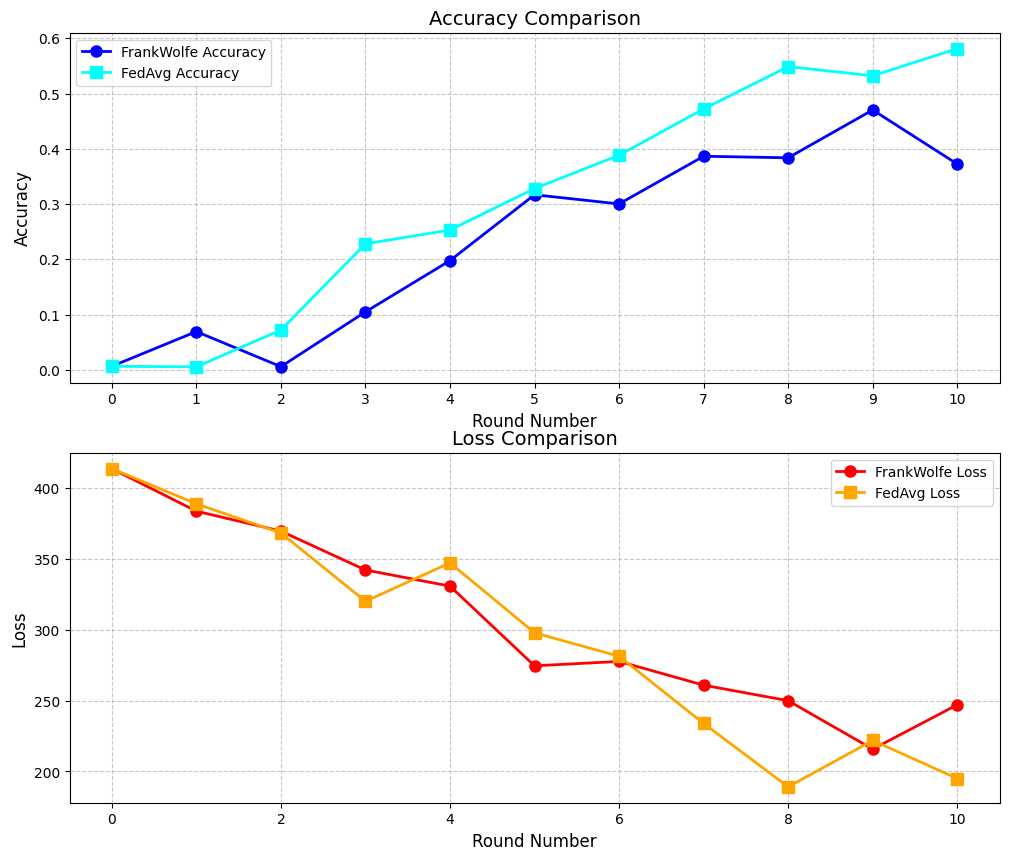

In [27]:
plot_metrics(hist, hist_fedavg)

In [28]:
log(
    INFO,
    "Size of the list with the model parameters: %s",
    len(parameters_for_each_round),
)

INFO flwr 2025-03-05 17:03:40,986 | 1532827960.py:1 | Size of the list with the model parameters: 11


                    INFO     Size of the list with the model parameters: 11                                  ]8;id=513297;file:///tmp/ipykernel_387635/1532827960.py\flwr]8;;\:]8;id=709106;file:///tmp/ipykernel_387635/1532827960.py#1\1]8;;\